In [1]:
# This notebook is for calculating the geodesic distance and connectivity distance of functional and structural matrices 
# Includes:
#      loading geodesic distance map and visualize
#      loading myelin map and visualize
#      loading functional and structural conn matrices and visualize / compare with geodesic
#      correlation between geodesic, myelin map and func / struct
#      spin test (whole brain / parcellated brain) correlation

In [1]:
import os
from neuromaps import images
import numpy as np
import nibabel as nib
from sklearn import preprocessing
from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage
from numpy import load
import seaborn as sns
import matplotlib.pyplot as plt
from neuromaps import stats
from neuromaps import datasets, images, nulls, resampling
from neuromaps import parcellate
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
import pandas as pd
from neuromaps import datasets
from neuromaps import images
from neuromaps import stats
from neuromaps.datasets import available_annotations
from neuromaps.datasets import available_tags
from neuromaps.datasets import fetch_annotation

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Setting path

In [2]:
main_path = "/srv/khan/users/sudesnac/00_Projects/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [3]:
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Conn_dist/"
fig_path = main_path + "/HumanBF-Parcellation/results/Conn_dist/figures/"

In [4]:
Func_results = main_path + "HumanBF-Parcellation/results/Func_HCPMMP/"
Diff_results = main_path + "HumanBF-Parcellation/results/Diff_7Tsubj/"
Fuse_results = main_path + "HumanBF-Parcellation/results/Fusion_grad/"
Gradc_results = main_path + "/HumanBF-Parcellation/results/Grad_corr/"

### Load & visualize geodesic distance (pial) + BF seed

In [5]:
# geodesic Distance
# data_dir = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/13_Funcparc/0_Funcparc_rhaast/basal_forebrain/resources/"
geodesic_lh = images.load_gifti(results_path + "seed-BASF_geodesic-distance-no-zeros.pial.lh.shape.gii")
geodesic_rh = images.load_gifti(results_path + "seed-BASF_geodesic-distance-no-zeros.pial.rh.shape.gii")

In [87]:
geodesic_lh_data = geodesic_lh.agg_data()
geodesic_rh_data = geodesic_rh.agg_data()
geodesic_data = np.concatenate((geodesic_lh_data, geodesic_rh_data))

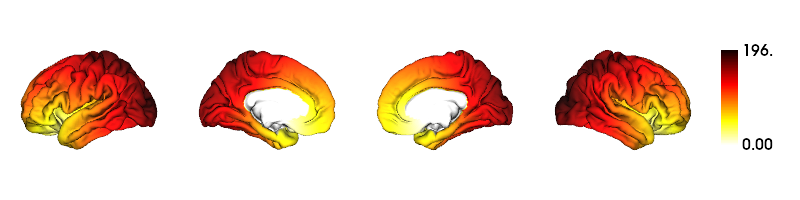

In [7]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[geodesic_data], size=(800, 200), cmap=['hot_r'], color_bar=True, embed_nb=True)

In [5]:
# getting the surface BF data
# seed_dir = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/13_Funcparc/0_Funcparc_rhaast/basal_forebrain/results/funcparc_icafix/group/atlas/"
BF_lh = images.load_gifti(results_path + "seed-BASF.L.bin.fsa5.shape.gii")
BF_rh = images.load_gifti(results_path + "seed-BASF.R.bin.fsa5.shape.gii")

In [6]:
BF_lh_data = BF_lh.agg_data()
BF_rh_data = BF_rh.agg_data()
BF_data = np.concatenate((BF_lh_data, BF_rh_data))

In [7]:
# scale the geodesic and BF data 
min_max_scaler = preprocessing.MinMaxScaler()
BF_scaled_data = min_max_scaler.fit_transform(BF_data.reshape(-1, 1))
#geodesic_scaled_data = min_max_scaler.fit_transform(geodesic_data.reshape(-1, 1))

In [8]:
np.where(BF_scaled_data == 1)

(array([11428, 16986]), array([0, 0]))

In [9]:
# change so the scaled data is binarized
BF_scaled_data = np.where(BF_scaled_data == 0.5, 1, BF_scaled_data)
np.where(BF_scaled_data==1)

(array([   78,   600,  1335,  1337,  2438,  3255,  3256,  3257,  5448,
         5452,  7014,  7015,  8476,  8477,  9873,  9874,  9875,  9878,
         9879,  9880, 10324, 10443, 11205, 11206, 11428, 11754, 11755,
        11756, 11757, 11758, 13125, 13126, 13723, 13728, 14570, 14571,
        14572, 15678, 16583, 16584, 16585, 16986, 17610, 17612, 17613,
        17614, 17616, 17617, 17618, 17619, 17620, 18752, 20086, 20087,
        20095, 20096]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

/tmp/ipykernel_987364/2906248618.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


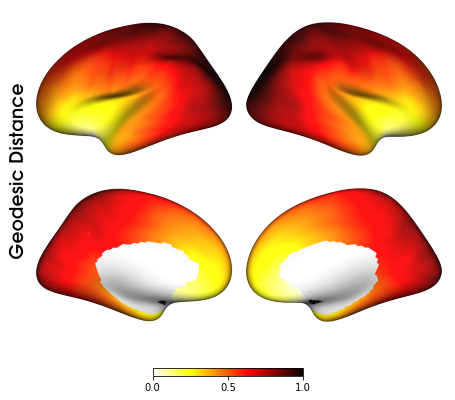

In [14]:
# plot both BF and geodesic distance together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Geodesic Distance']}, brightness=.8)
p.add_layer(geodesic_scaled_data.reshape([20484]), cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'wholebrain_geodesic_dist_BFseed_grid.png', dpi=300)

### Load & visualize average T1w/T2w (Myelin Maps)

In [15]:
myelin_lh = images.load_gifti(results_path + "source-hcps1200_desc-myelinmap_space-fsaverage5_den-10k_hemi-L_feature.func.gii")
myelin_rh = images.load_gifti(results_path + "source-hcps1200_desc-myelinmap_space-fsaverage5_den-10k_hemi-R_feature.func.gii")

In [16]:
myelin_lh_data = myelin_lh.agg_data()
myelin_rh_data = myelin_rh.agg_data()
myelin_data = np.concatenate((myelin_lh_data, myelin_rh_data))

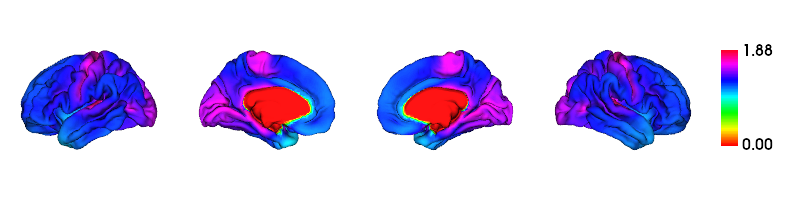

In [17]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[myelin_data], size=(800, 200), cmap=['hsv'], color_bar=True, embed_nb=True)

In [18]:
myelin_scaled_data = min_max_scaler.fit_transform(myelin_data.reshape(-1, 1))

/tmp/ipykernel_987364/969226583.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


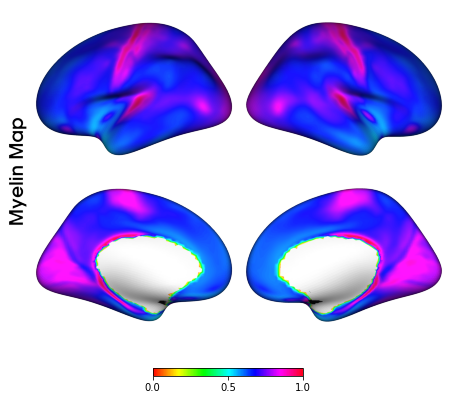

In [20]:
# plot both BF and myelin map together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Myelin Map']}, brightness=.8)
p.add_layer(myelin_scaled_data.reshape([20484]), cmap='hsv', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_myelin_map_BFseed_grid.png', dpi=300)

### Loading functional and diffusion connectivity data

#### Functional data

In [22]:
func_corr = pd.read_csv(Func_results + f'Func_HCPMMP_corr-avgFC.csv')

In [24]:
func_ctx = np.nanmean(func_corr,axis=0).reshape([360,1])

#### Diffusion data

In [25]:
diff_corr = pd.read_csv(Diff_results + f'Diff_7Tsubj_corr-avgFC.csv')

In [27]:
log_diff_corr = np.log(diff_corr)

In [28]:
diff_ctx = np.nanmean(log_diff_corr,axis=0).reshape([360,1])

#### Fused data

In [38]:
fuse_corr = pd.read_csv(Fuse_results + f'Fused-matrix_corrAvgFC.csv').to_numpy()

In [39]:
sum_fused = (fuse_corr[:,:360] + fuse_corr[:,360:])

In [40]:
fuse_ctx = np.nanmean(sum_fused,axis=0).reshape([360,1])

#### Visualize

In [8]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [41]:
func_cortex = map_to_labels(func_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
diff_cortex = map_to_labels(diff_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
fuse_cortex = map_to_labels(fuse_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

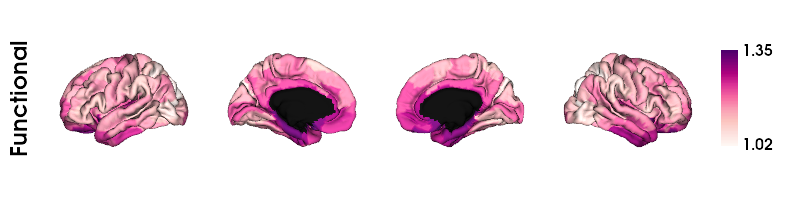

In [31]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[func_cortex], size=(800, 200), cmap=['RdPu'], label_text=['Functional'], color_bar=True, embed_nb=True)

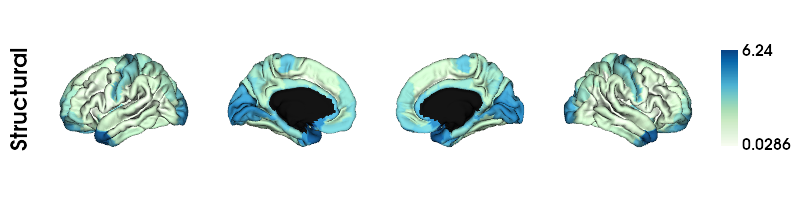

In [32]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[diff_cortex], size=(800, 200), cmap=['GnBu'], label_text=['Structural'], color_bar=True, embed_nb=True)

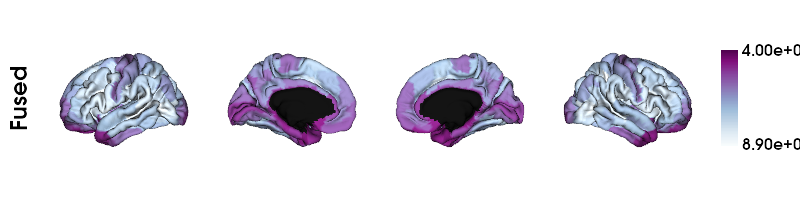

In [42]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[fuse_cortex], size=(800, 200), cmap=['BuPu'], label_text=['Fused'], color_bar=True, embed_nb=True)

#### Rescale data

In [43]:
# scale the  data 
min_max_scaler = preprocessing.MinMaxScaler()
func_scaled_ctx = min_max_scaler.fit_transform(func_cortex.reshape(-1, 1))
diff_scaled_ctx = min_max_scaler.fit_transform(diff_cortex.reshape(-1, 1))
fuse_scaled_ctx = min_max_scaler.fit_transform(fuse_cortex.reshape(-1, 1))

In [44]:
gdist_data = {'labels':surf_labels.reshape([20484]), 'geodesic':geodesic_scaled_data.reshape([20484]), 'myelin':myelin_scaled_data.reshape([20484]), 
              'functional':func_scaled_ctx.reshape([20484]), 'structural':diff_scaled_ctx.reshape([20484]), 'fused':fuse_scaled_ctx.reshape([20484])}
gdist_df = pd.DataFrame(data=gdist_data)

In [45]:
gdist_df.head(10)

labels  geodesic    myelin  functional  structural     fused
0      54  0.796473  0.854568    0.469834    0.415276  0.564902
1      46  0.911204  0.691224    0.210992    0.404432  0.392915
2      41  0.564919  0.721838    0.521383    0.114198  0.254639
3      87  0.552300  0.641402    0.341724    0.418003  0.485461
4      99  0.450188  0.707502    0.377407    0.144557  0.192630
5     149  0.708620  0.657952    0.319306    0.264461  0.313061
6       6  0.846829  0.774055    0.269942    0.518669  0.498331
7     121  0.613734  0.725570    0.589872    0.450273  0.667622
8       0  0.000000  0.000000         NaN         NaN       NaN
9     111  0.167580  0.651792    0.514393    0.061559  0.187984

In [52]:
# set the geodesic medial wall to nan instead of 0 to match with other 
gdist_df.loc[gdist_df.labels == 0, 'geodesic'] = np.nan
gdist_df.loc[gdist_df.labels == 0, 'myelin'] = np.nan
gdist_df.loc[gdist_df.labels == 0, 'functional'] = np.nan
gdist_df.loc[gdist_df.labels == 0, 'structural'] = np.nan
gdist_df.loc[gdist_df.labels == 0, 'fused'] = np.nan

In [61]:
gdist_df.loc[(gdist_df['fused'] == 0)]

Empty DataFrame
Columns: [labels, geodesic, myelin, functional, structural, fused]
Index: []

In [53]:
gdist_df.loc[gdist_df.labels == 80, 'structural'] = 0.000001
gdist_df.loc[gdist_df.labels == 80, 'fused'] = 0.000001
gdist_df.loc[gdist_df.labels == 260, 'structural'] = 0.000001
gdist_df.loc[gdist_df.labels == 16, 'functional'] = 0.000001

In [58]:
#pd.set_option('display.max_rows', None)
gdist_df.loc[(gdist_df['geodesic'] == 0)]

labels  geodesic    myelin  functional  structural     fused
147       110       0.0  0.796825    0.892267    0.930530  0.963492
161       120       0.0  0.822729    0.900412    0.689449  0.907633
328       120       0.0  0.674891    0.900412    0.689449  0.907633
329       120       0.0  0.580802    0.900412    0.689449  0.907633
358       120       0.0  0.830250    0.900412    0.689449  0.907633
...       ...       ...       ...         ...         ...       ...
20176     300       0.0  0.783296    0.867117    0.689449  0.894981
20200     300       0.0  0.435796    0.867117    0.689449  0.894981
20206     300       0.0  0.620181    0.867117    0.689449  0.894981
20207     300       0.0  0.734735    0.867117    0.689449  0.894981
20208     299       0.0  0.940493    0.932913    0.597421  0.883192

[243 rows x 6 columns]

In [59]:
pd.DataFrame(gdist_df).to_csv(results_path + 'rescaled_geodesic_myelin_func_struct_fuse_data.csv', index=False)

In [6]:
gdist_df = pd.read_csv(results_path + 'rescaled_geodesic_myelin_func_struct_fuse_data.csv')

/tmp/ipykernel_378710/2774927413.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


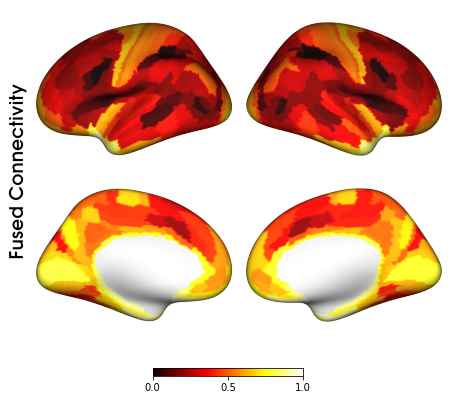

In [66]:
# Visualize
# plot both BF and geodesic distance together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Fused Connectivity']}, brightness=.8)
#p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
#p.add_layer(gdist_df['functional'].values, cmap='hot', cbar=True, color_range=[0,1])
#p.add_layer(gdist_df['structural'].values, cmap='hot', cbar=True, color_range=[0,1])
p.add_layer(gdist_df['fused'].values, cmap='hot', cbar=True, color_range=[0,1])
fig = p.build()
fig.show()
#fig.savefig(fig_path+'geodesic_connectivity_parc-grid.png', dpi=300)

### Getting Functional G1 & G2 weighted cortical maps for correlation

In [7]:
Func_GCtx = np.load(Func_results + 'Func_HCPMMP_Gradient-weighted_CorticalConnectivity.npz')
Func_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx']

In [8]:
func_g1 = Func_GCtx['G1_Ctx']
func_g2 = Func_GCtx['G2_Ctx']

In [9]:
func_g1_ctx = np.nanmean(func_g1,axis=0).reshape([360,1])
func_g2_ctx = np.nanmean(func_g2,axis=0).reshape([360,1])

In [10]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [11]:
func_g1_cortex = map_to_labels(func_g1_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
func_g2_cortex = map_to_labels(func_g2_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

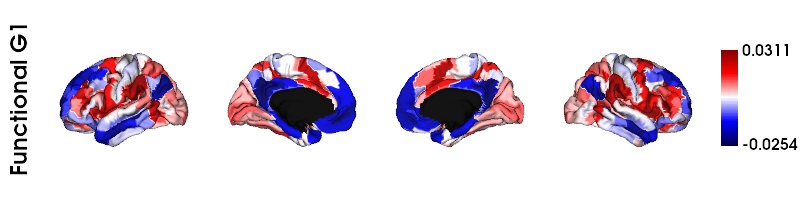

In [12]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[func_g1_cortex], size=(800, 200), cmap=['seismic'], label_text=['Functional G1'], color_bar=True, embed_nb=True)

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
funcG1_scaled_ctx = min_max_scaler.fit_transform(func_g1_cortex.reshape(-1, 1))
funcG2_scaled_ctx = min_max_scaler.fit_transform(func_g2_cortex.reshape(-1, 1))

### Getting structural G1 & G2 weighted cortical maps for correlation

In [14]:
Diff_GCtx = np.load(Diff_results + 'Diff_7Tsubj_Gradient-weighted_CorticalConnectivity.npz')
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

In [15]:
diff_g1 = Diff_GCtx['G1_Ctx']
diff_g2 = Diff_GCtx['G2_Ctx']

In [16]:
diff_g1_ctx = np.nanmean(diff_g1,axis=0).reshape([360,1])
diff_g2_ctx = np.nanmean(diff_g2,axis=0).reshape([360,1])

In [17]:
diff_g1_cortex = map_to_labels(diff_g1_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
diff_g2_cortex = map_to_labels(diff_g2_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

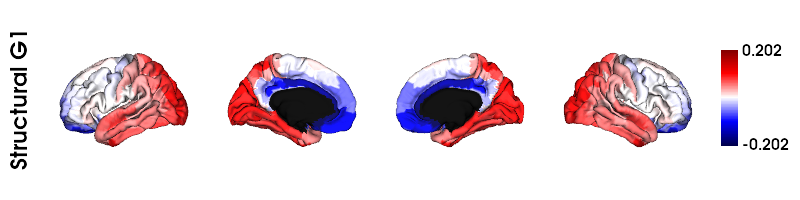

In [18]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[diff_g1_cortex], size=(800, 200), cmap=['seismic'], label_text=['Structural G1'], color_range='sym',color_bar=True, embed_nb=True)

In [19]:
min_max_scaler = preprocessing.MinMaxScaler()
diffG1_scaled_ctx = min_max_scaler.fit_transform(diff_g1_cortex.reshape(-1, 1))
diffG2_scaled_ctx = min_max_scaler.fit_transform(diff_g2_cortex.reshape(-1, 1))

### Getting cortical residual data

In [101]:
weighted_sqresid = pd.read_csv(Gradc_results + 'Gradient-weighted-map_Struct_vs_Func_linear_least-squares_regression_weighted-s6-f4_residuals_statsmodels.csv')

In [102]:
weighted_sumsq = weighted_sqresid.sum(axis=1).to_numpy()
weighted_sumsq.shape

(360,)

In [103]:
weighted_sumsq_cortex = map_to_labels(weighted_sumsq, surf_labels, mask=mask, fill=np.nan)

In [105]:
weighted_resid_scaled_data = min_max_scaler.fit_transform(weighted_sumsq_cortex.reshape(-1, 1))

In [106]:
wresid_ctx_data = {'wresidC':weighted_resid_scaled_data.reshape([20484])}
wresid_df = pd.DataFrame(data=wresid_ctx_data)

In [107]:
wresid_df.head(5)

wresidC
0  0.010250
1  0.119060
2  0.179069
3  0.102859
4  0.410765

### Saving all whole brain data

In [22]:
gdist_df.head(5)

labels  geodesic    myelin  functional  structural     fused
0      54  0.796473  0.854568    0.469834    0.415276  0.564902
1      46  0.911204  0.691224    0.210992    0.404432  0.392915
2      41  0.564919  0.721838    0.521383    0.114198  0.254639
3      87  0.552300  0.641402    0.341724    0.418003  0.485461
4      99  0.450188  0.707502    0.377407    0.144557  0.192630

In [27]:
GradCtx_data = {'funcG1':funcG1_scaled_ctx.reshape([20484]), 'diffG1':diffG1_scaled_ctx.reshape([20484]),
                'funcG2':funcG2_scaled_ctx.reshape([20484]), 'diffG2':diffG2_scaled_ctx.reshape([20484])}
GradCtx_df = pd.DataFrame(data=GradCtx_data)

In [28]:
GradCtx_df.head(5)

funcG1    diffG1    funcG2    diffG2
0  0.480979  0.550129  0.679370  0.685803
1  0.687947  0.918590  0.435305  0.664741
2  0.649486  0.511140  0.660174  0.897476
3  0.293482  0.565580  0.422960  0.659776
4  0.820415  0.617225  0.693195  0.627569

In [29]:
wholeB_df = pd.concat([gdist_df, GradCtx_df], axis=1)
wholeB_df

labels  geodesic    myelin  functional  structural     fused    funcG1  \
0          54  0.796473  0.854568    0.469834    0.415276  0.564902  0.480979   
1          46  0.911204  0.691224    0.210992    0.404432  0.392915  0.687947   
2          41  0.564919  0.721838    0.521383    0.114198  0.254639  0.649486   
3          87  0.552300  0.641402    0.341724    0.418003  0.485461  0.293482   
4          99  0.450188  0.707502    0.377407    0.144557  0.192630  0.820415   
...       ...       ...       ...         ...         ...       ...       ...   
20479     314  0.536869  0.601904    0.777940    0.342632  0.671027  0.418248   
20480     314  0.517557  0.604135    0.777940    0.342632  0.671027  0.418248   
20481     315  0.500530  0.611836    0.813672    0.429926  0.763871  0.503566   
20482     315  0.508823  0.638348    0.813672    0.429926  0.763871  0.503566   
20483     315  0.518316  0.660134    0.813672    0.429926  0.763871  0.503566   

         diffG1    funcG2    diffG2  
0      0.550129  0.679370  0.685803  
1      0.918590  0.435305  0.664741  
2      0.511140  0.660174  0.897476  
3      0.565580  0.422960  0.659776  
4      0.617225  0.693195  0.627569  
...         ...       ...       ...  
20479  0.828982  0.161854  0.402273  
20480  0.828982  0.161854  0.402273  
20481  0.894323  0.343278  0.501030  
20482  0.894323  0.343278  0.501030  
20483  0.894323  0.343278  0.501030  

[20484 rows x 10 columns]

In [109]:
wholeB_df = pd.concat([wholeB_df, wresid_df], axis=1)
wholeB_df.head(5)

labels  geodesic    myelin  functional  structural     fused    funcG1  \
0      54  0.796473  0.854568    0.469834    0.415276  0.564902  0.480979   
1      46  0.911204  0.691224    0.210992    0.404432  0.392915  0.687947   
2      41  0.564919  0.721838    0.521383    0.114198  0.254639  0.649486   
3      87  0.552300  0.641402    0.341724    0.418003  0.485461  0.293482   
4      99  0.450188  0.707502    0.377407    0.144557  0.192630  0.820415   

     diffG1    funcG2    diffG2   wresidC  
0  0.550129  0.679370  0.685803  0.010250  
1  0.918590  0.435305  0.664741  0.119060  
2  0.511140  0.660174  0.897476  0.179069  
3  0.565580  0.422960  0.659776  0.102859  
4  0.617225  0.693195  0.627569  0.410765

In [110]:
pd.DataFrame(wholeB_df).to_csv(results_path + 'rescaled_whole_brain_all_data.csv', index=False)

### Loading all whole brain data

In [111]:
wholeB_df = pd.read_csv(results_path + 'rescaled_whole_brain_all_data.csv')

In [112]:
wholeB_df.head(5)

labels  geodesic    myelin  functional  structural     fused    funcG1  \
0      54  0.796473  0.854568    0.469834    0.415276  0.564902  0.480979   
1      46  0.911204  0.691224    0.210992    0.404432  0.392915  0.687947   
2      41  0.564919  0.721838    0.521383    0.114198  0.254639  0.649486   
3      87  0.552300  0.641402    0.341724    0.418003  0.485461  0.293482   
4      99  0.450188  0.707502    0.377407    0.144557  0.192630  0.820415   

     diffG1    funcG2    diffG2   wresidC  
0  0.550129  0.679370  0.685803  0.010250  
1  0.918590  0.435305  0.664741  0.119060  
2  0.511140  0.660174  0.897476  0.179069  
3  0.565580  0.422960  0.659776  0.102859  
4  0.617225  0.693195  0.627569  0.410765

#### Visualize whole brain

/tmp/ipykernel_987364/1735998896.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


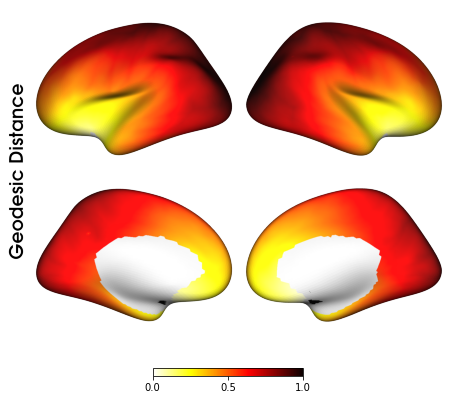

In [32]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Geodesic Distance']}, brightness=.8)
p.add_layer(wholeB_df['geodesic'].values, cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_myelin_map_BFseed_grid.png', dpi=300)

### Creating parcellated geodesic and myelin data to match func and diff data

In [99]:
#glasser_parc = fetch_parcellation("fsaverage5", "glasser", 360)

In [113]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')

In [114]:
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

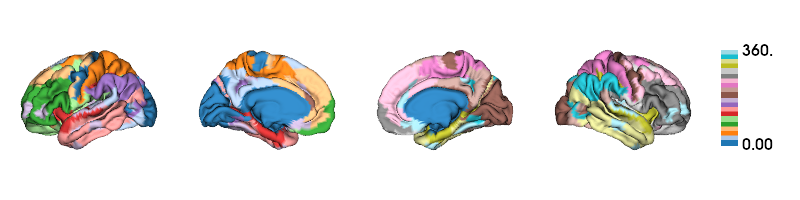

In [35]:
# visualize the parcellation data to double check
hm_lh, hm_rh = hcpmmp_parcellation
parc_L_data = hm_lh.agg_data()
parc_R_data = hm_rh.agg_data()
parc_data = np.concatenate((parc_L_data, parc_R_data))
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[parc_data], size=(800, 200), cmap=['tab20'], color_bar=True, embed_nb=True)

In [115]:
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [12]:
wholeB_df = pd.read_csv(results_path + 'rescaled_whole_brain_all_data.csv')

In [117]:
# get data
geodesic_scaled_data = wholeB_df['geodesic'].values
myelin_scaled_data = wholeB_df['myelin'].values
func_scaled_data = wholeB_df['functional'].values
diff_scaled_data = wholeB_df['structural'].values
fused_scaled_data = wholeB_df['fused'].values
funcG1_scaled_data = wholeB_df['funcG1'].values
funcG2_scaled_data = wholeB_df['funcG2'].values
diffG1_scaled_data = wholeB_df['diffG1'].values
diffG2_scaled_data = wholeB_df['diffG2'].values
wresid_scaled_data = wholeB_df['wresidC'].values

In [119]:
geodesic_parc = hcpmmp.transform(geodesic_scaled_data, 'fsaverage', ignore_background_data=True)

In [135]:
myelin_parc = hcpmmp.transform(myelin_scaled_data, 'fsaverage', ignore_background_data=True)

In [121]:
func_parc = hcpmmp.transform(func_scaled_data, 'fsaverage', ignore_background_data=True)
diff_parc = hcpmmp.transform(diff_scaled_data, 'fsaverage', ignore_background_data=True)
fused_parc = hcpmmp.transform(fused_scaled_data, 'fsaverage', ignore_background_data=True)

In [122]:
funcG1_parc = hcpmmp.transform(funcG1_scaled_data, 'fsaverage', ignore_background_data=True)
funcG2_parc = hcpmmp.transform(funcG2_scaled_data, 'fsaverage', ignore_background_data=True)

In [123]:
diffG1_parc = hcpmmp.transform(diffG1_scaled_data, 'fsaverage', ignore_background_data=True)
diffG2_parc = hcpmmp.transform(diffG2_scaled_data, 'fsaverage', ignore_background_data=True)

In [118]:
wresid_parc = hcpmmp.transform(wresid_scaled_data, 'fsaverage', ignore_background_data=True)

### Saving / loading parcellated data to / from csv file

In [124]:
# Saving parcellated data to csv file
parc_data = {'geodesic':geodesic_parc, 'myelin':myelin_parc, 'functional':func_parc, 'structural':diff_parc, 
             'fused':fused_parc, 'funcG1':funcG1_parc, 'funcG2':funcG2_parc, 'diffG1':diffG1_parc,'diffG2':diffG2_parc,
            'wresidC':wresid_parc}
parc_df = pd.DataFrame(data=parc_data)

In [125]:
pd.DataFrame(parc_df).to_csv(results_path + 'rescaled_parc_brain_all_data.csv', index=False)

In [18]:
parc_df = pd.read_csv(results_path + 'rescaled_parc_brain_all_data.csv')

In [19]:
parc_df.head(5)

geodesic    myelin  functional  structural     fused    funcG1    funcG2  \
0  0.720368  0.824546    0.563640    0.805695  0.795516  0.668343  0.246482   
1  0.755832  0.789361    0.164174    0.112599  0.038210  0.590819  0.544861   
2  0.755834  0.794104    0.138740    0.433660  0.363351  0.619504  0.512658   
3  0.721149  0.803279    0.377697    0.731491  0.665120  0.591279  0.390270   
4  0.777247  0.788013    0.315332    0.684552  0.612339  0.589598  0.380564   

     diffG1    diffG2   wresidC  
0  0.915610  0.540071  0.100994  
1  0.750025  0.702449  0.050152  
2  0.936075  0.658498  0.051173  
3  0.897551  0.587814  0.044553  
4  0.930242  0.568697  0.026488

In [20]:
geodesic_parc = parc_df['geodesic'].values
myelin_parc = parc_df['myelin'].values
func_parc = parc_df['functional'].values
diff_parc = parc_df['structural'].values
fused_parc = parc_df['fused'].values
funcG1_parc = parc_df['funcG1'].values
funcG2_parc = parc_df['funcG2'].values
diffG1_parc = parc_df['diffG1'].values
diffG2_parc = parc_df['diffG2'].values
wresid_parc = parc_df['wresidC'].values

### Visualize parcellated data

In [30]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [31]:
geodesic_parc_cortex = map_to_labels(parc_df['geodesic'].values,surf_labels, mask=mask, fill=np.nan)
myelin_parc_cortex = map_to_labels(parc_df['myelin'].values,surf_labels, mask=mask, fill=np.nan)

In [32]:
func_parc_cortex = map_to_labels(parc_df['functional'].values,surf_labels, mask=mask, fill=np.nan)
diff_parc_cortex = map_to_labels(parc_df['structural'].values,surf_labels, mask=mask, fill=np.nan)
funcG1_parc_cortex = map_to_labels(parc_df['funcG1'].values,surf_labels, mask=mask, fill=np.nan)
diffG1_parc_cortex = map_to_labels(parc_df['diffG1'].values,surf_labels, mask=mask, fill=np.nan)
wresid_parc_cortex = map_to_labels(parc_df['wresidC'].values,surf_labels, mask=mask, fill=np.nan)

/tmp/ipykernel_18193/1909236036.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


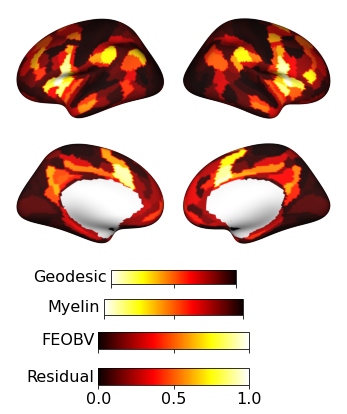

In [36]:
# Visualize & save for figs

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)
#label_text={'left':['Geodesic Distance']}
#kws = {'decimals': 1,'fontsize': 16}
p.add_layer(geodesic_parc_cortex, cmap='hot_r', cbar=True, color_range=[0,1], cbar_label='Geodesic')
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
p.add_layer(myelin_parc_cortex, cmap='hot_r', cbar=True, color_range=[0,1], cbar_label='Myelin')
p.add_layer(MicCorr_parc_cortex, cmap='hot', cbar=True, color_range=[0,1], cbar_label='FEOBV')
p.add_layer(wresid_parc_cortex, cmap='hot', cbar=True, color_range=[0,1], cbar_label='Residual')
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
#fig.savefig(fig_path+'parc_geodesic_BFseed_grid.png', dpi=300)

/tmp/ipykernel_25229/2238528347.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


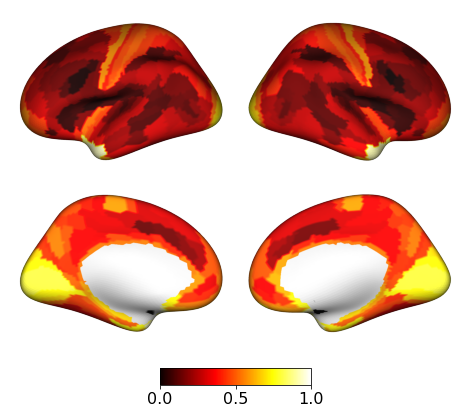

In [36]:
# Visualize & save for figs

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)
#label_text={'left':['Geodesic Distance']}
#p.add_layer(wresid_parc_cortex, cmap='Spectral_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
#p.add_layer(func_parc_cortex, cmap='hot', cbar=True, color_range=[0,1])
p.add_layer(diff_parc_cortex, cmap='hot', cbar=True, color_range=[0,1])
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
#fig.savefig(fig_path+'parc_func-conn_BFseed_grid.png', dpi=300)

/tmp/ipykernel_25229/4204490856.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


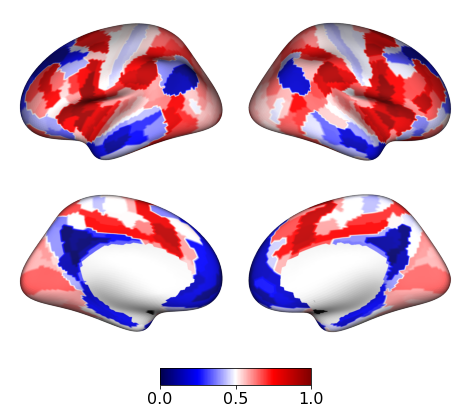

In [45]:
# Visualize & save for figs

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)
#label_text={'left':['Geodesic Distance']}
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
p.add_layer(funcG1_parc_cortex, cmap='seismic', cbar=True, color_range=[0,1])
#p.add_layer(diffG1_parc_cortex, cmap='seismic', cbar=True, color_range=[0,1])
#cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
fig.savefig(fig_path+'parc_func-G1_BFseed_grid.png', dpi=300)

/tmp/ipykernel_987364/3013460987.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


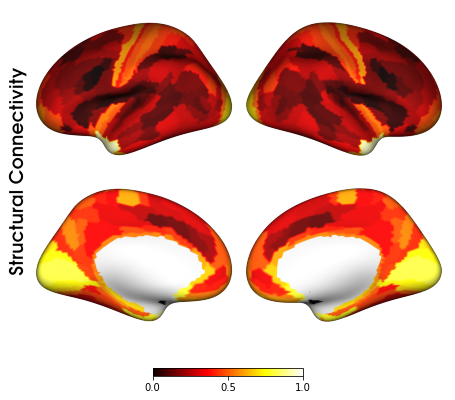

In [37]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Structural Connectivity']}, brightness=.8)
p.add_layer(wholeB_df['structural'].values, cmap='hot', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'parc_structural_conn_BFseed_grid.png', dpi=300)

/tmp/ipykernel_987364/4124734597.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


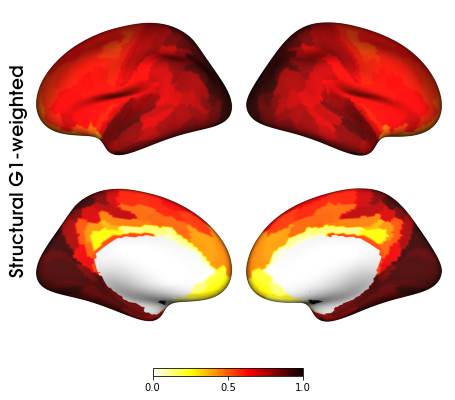

In [40]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Structural G1-weighted']}, brightness=.8)
p.add_layer(wholeB_df['diffG1'].values, cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'parc_diff-G1_BFseed_grid.png', dpi=300)

## Correlations

#### Load data for stats

In [63]:
wholeB_df = pd.read_csv(results_path + 'rescaled_whole_brain_all_data.csv')
parc_df = pd.read_csv(results_path + 'rescaled_parc_brain_all_data.csv')

In [38]:
geodesic_scaled_data = wholeB_df['geodesic'].values
myelin_scaled_data = wholeB_df['myelin'].values
func_scaled_data = wholeB_df['functional'].values
diff_scaled_data = wholeB_df['structural'].values
diffG1_scaled_data = wholeB_df['diffG1'].values

In [64]:
geodesic_parc = parc_df['geodesic'].values
func_parc = parc_df['functional'].values
funcG1_parc = parc_df['funcG1'].values
funcG2_parc = parc_df['funcG2'].values
diff_parc = parc_df['structural'].values
diffG1_parc = parc_df['diffG1'].values
diffG2_paprc = parc_df['diffG2'].values
wresid_parc = parc_df['wresidC'].values

#### Yeo Network for color ref

In [57]:
from matplotlib.colors import ListedColormap
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.datasets import fetch_parcellation
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata

surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)
yeo_colormap_gray = np.concatenate((np.array([[0.7, 0.7, 0.7]]), yeo_colormap))
yeoCols = ListedColormap(yeo_colormap_gray)

/tmp/ipykernel_7453/4120515300.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


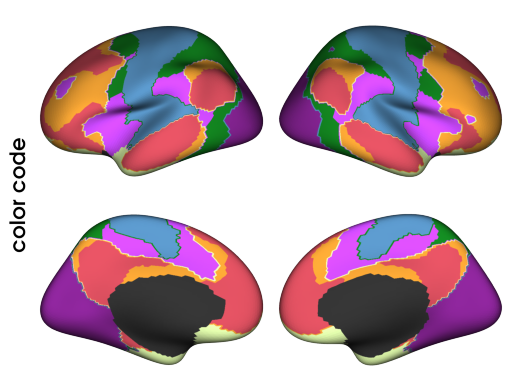

In [9]:
# Visualize network color ref

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), label_text={'left':['color code']}, brightness=.8)
p.add_layer(yeo_networks, cmap=yeoCols, cbar=False)
fig = p.build()
fig.show()

In [58]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [59]:
network_parc = hcpmmp.transform(yeo_networks, 'fsaverage', ignore_background_data=True)

#### Geodesic Distance: parcellated func and diff

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


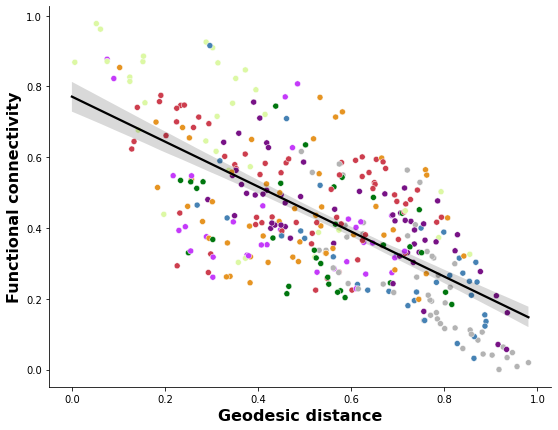

In [48]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, func_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


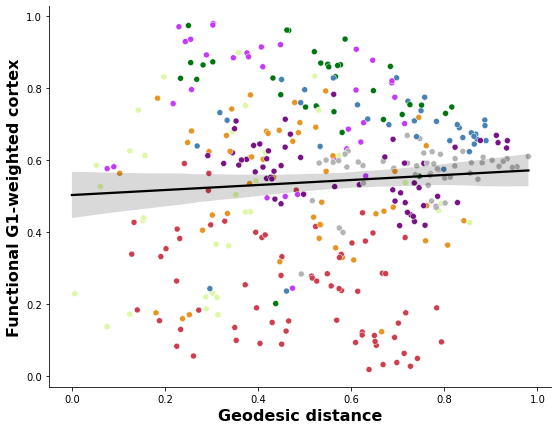

In [49]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, funcG1_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Functional G1-weighted cortex', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional G1-weighted cortical map", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=funcG1_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_G1-weighted_cortical_map.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


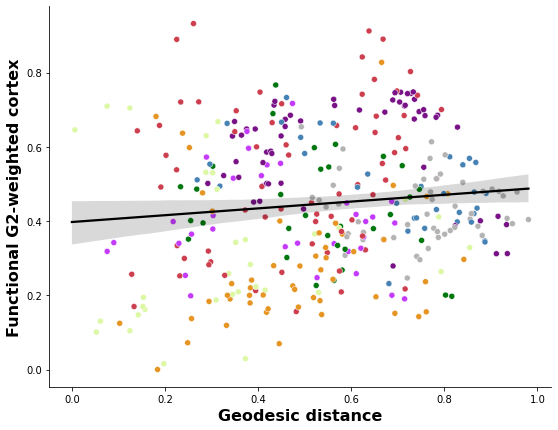

In [50]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, funcG2_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Functional G2-weighted cortex', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional G2-weighted cortical map", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=funcG2_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_G2-weighted_cortical_map.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


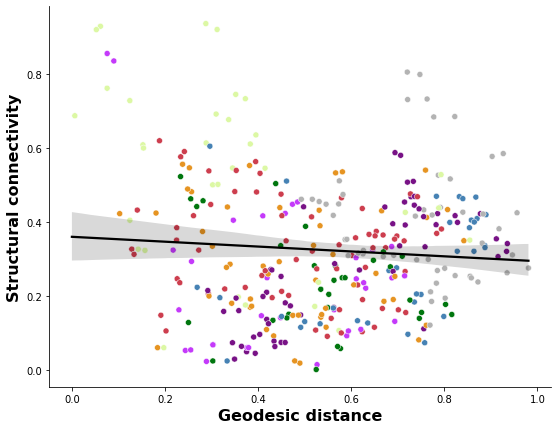

In [51]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, diff_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


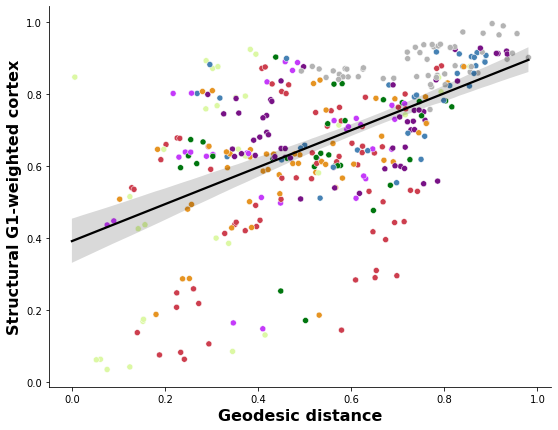

In [60]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, diffG1_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Structural G1-weighted cortex', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Structural G1-weighted cortical map", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diffG1_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Structural_G1-weighted_cortical_map.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


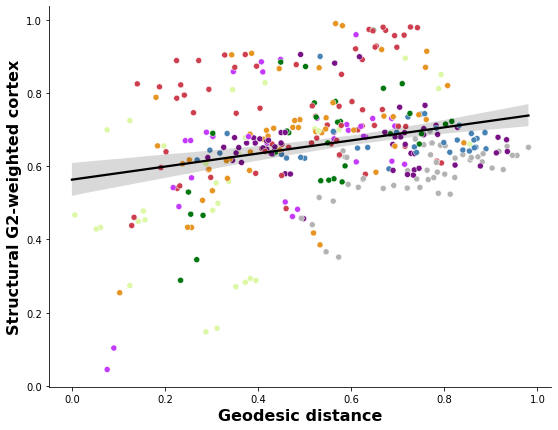

In [53]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, diffG2_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Structural G2-weighted cortex', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Structural G2-weighted cortical map", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diffG2_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Structural_G2-weighted_cortical_map.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


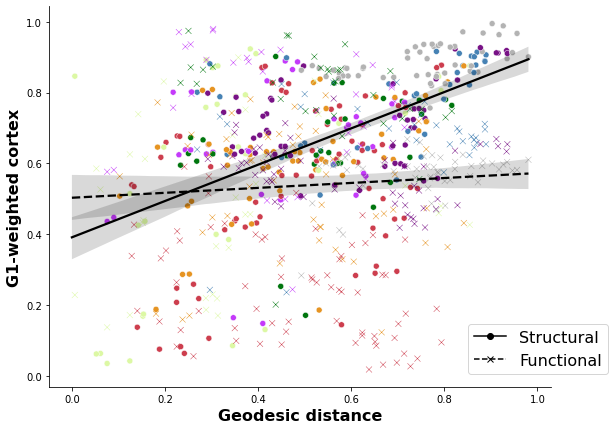

In [54]:
from matplotlib.lines import Line2D
# Plot scatterplot colorcoded for XYZ coordinates
#fig, ax = plt.subplots(figsize=(9,7))
fig = plt.figure(figsize=(9,7))

#ay = ax.twiny()

#ax.scatter(x=geodesic_parc, y=diffG1_parc, )
#ay.scatter(x=geodesic_parc, y=funcG1_parc, marker='d')
ax = sns.scatterplot(geodesic_parc, diffG1_parc, hue=network_parc, palette=yeoCols)
ax = sns.scatterplot(geodesic_parc, funcG1_parc, hue=network_parc, palette=yeoCols, marker='x')
ax.legend([],[], frameon=False)
ax.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax.set_ylabel('G1-weighted cortex', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Structural G1-weighted cortical map", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diffG1_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax)
sns.despine()

sns.regplot(
    x=geodesic_parc,
    y=funcG1_parc,
    scatter=False, line_kws={'color': 'black', 'ls':'--'},
    ax=ax)
sns.despine()

custom = [Line2D([], [], marker='o', color='black', linestyle='-'),
          Line2D([], [], marker='x', color='black', linestyle='--')]

fig.legend(custom, ['Structural','Functional'], fontsize=16, loc='center right', bbox_to_anchor=(1.0, 0.2))
plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_StrucFunc_G1-weighted_cortical_map.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


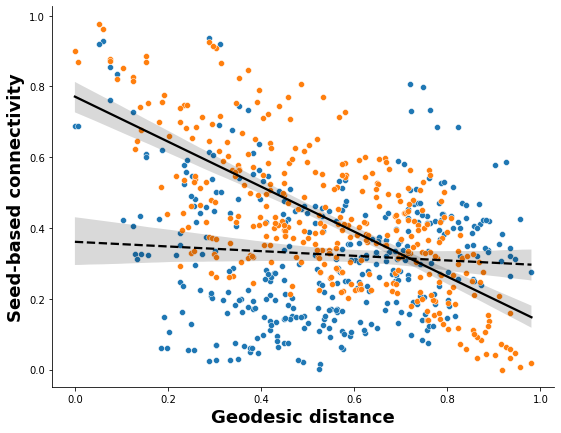

In [100]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(9,7))

ax = sns.scatterplot(geodesic_parc, diff_parc)#, hue=network_parc, palette=yeoCols, marker='x')
ax = sns.scatterplot(geodesic_parc, func_parc)#, hue=network_parc, palette=yeoCols)
ax.legend([],[], frameon=False)
ax.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax.set_ylabel('Seed-based connectivity', weight='bold', fontsize=18)

# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black', 'ls':'--'},
    ax=ax)
sns.despine()

sns.regplot(
    x=geodesic_parc,
    y=func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax)
sns.despine()

#custom = [Line2D([], [], marker='o', markerfacecolor='#ff7f0e', linestyle='-', color='black'),
          #Line2D([], [], marker='o', markerfacecolor='#1f77b4', linestyle='--', color='black')]

#fig.legend(custom, ['Functional','Structural'], fontsize=16, loc='center right', bbox_to_anchor=(1.1, 0.2))
plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_StrucFunc_Connectivity_no-legend.png', dpi=300, bbox_inches='tight')

plt.show()

In [53]:
print(sns.color_palette().as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


#### weighted gradient-weighted average cortical residual 

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


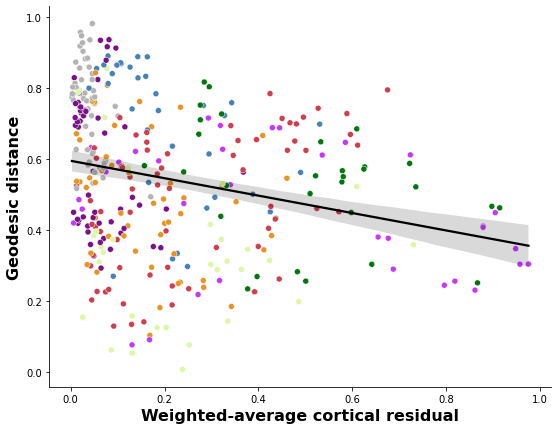

In [41]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, geodesic_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=geodesic_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


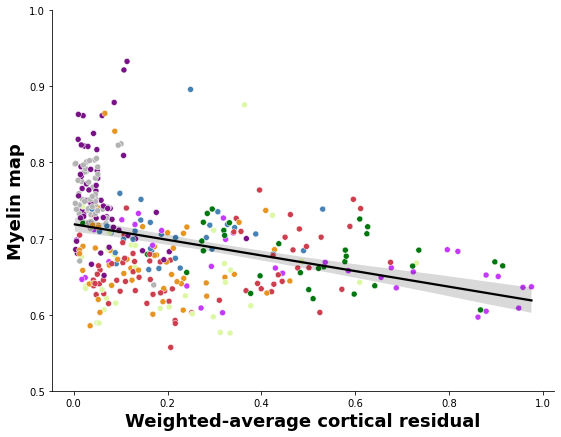

In [103]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, myelin_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Myelin map', weight='bold', fontsize=18)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=18)
ax1.axes.set_ylim(0.5, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=myelin_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin-map-asY_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


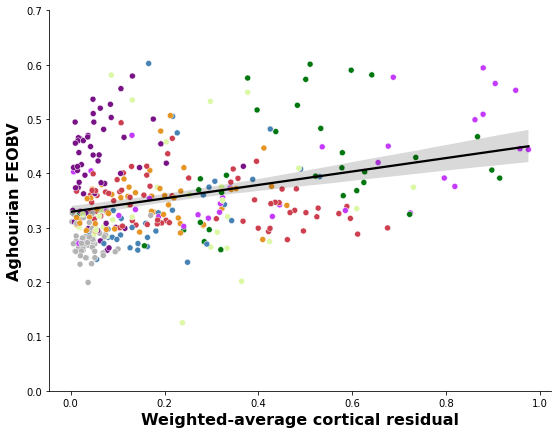

In [106]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, Aghourian_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=Aghourian_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Aghourian_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


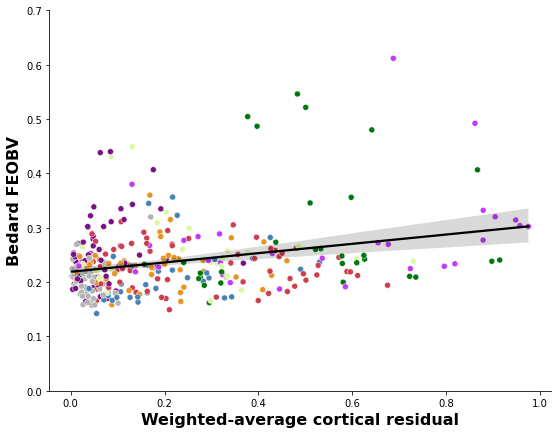

In [105]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, Bedard_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=Bedard_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Bedard_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


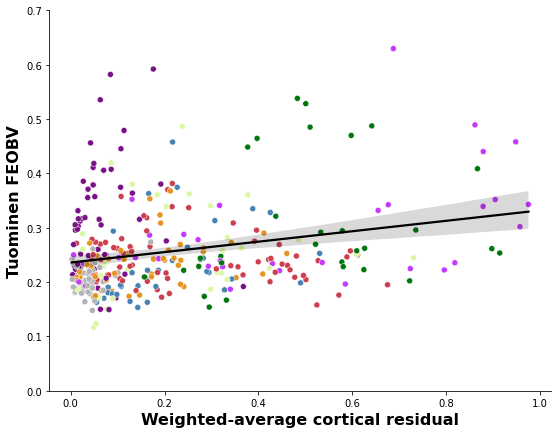

In [104]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, Tuominen_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=Tuominen_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Tuominen_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


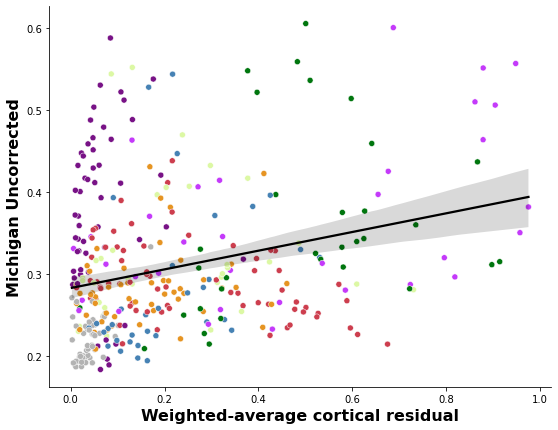

In [65]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, MicUnc_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Michigan Uncorrected', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=MicUnc_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_MichiganUnc_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


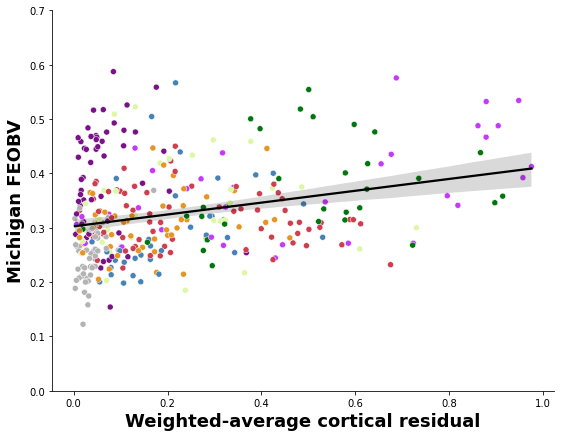

In [102]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, MicCorr_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Michigan FEOBV', weight='bold', fontsize=18)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=18)
ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=MicCorr_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_MichiganCorr_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

#### fused data

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


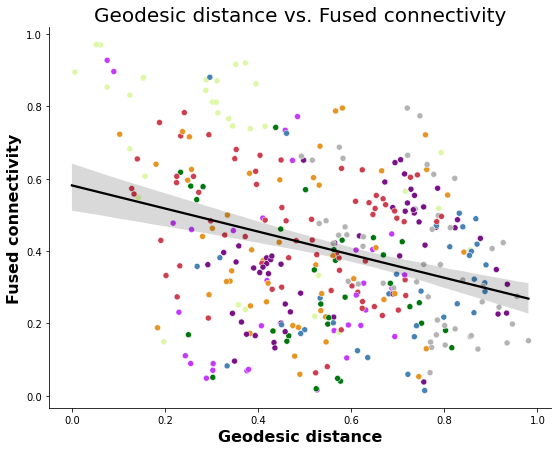

In [156]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, fused_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Fused connectivity', weight='bold', fontsize=16)

plt.title("Geodesic distance vs. Fused connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=fused_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Fused_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

#### Myelin map

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


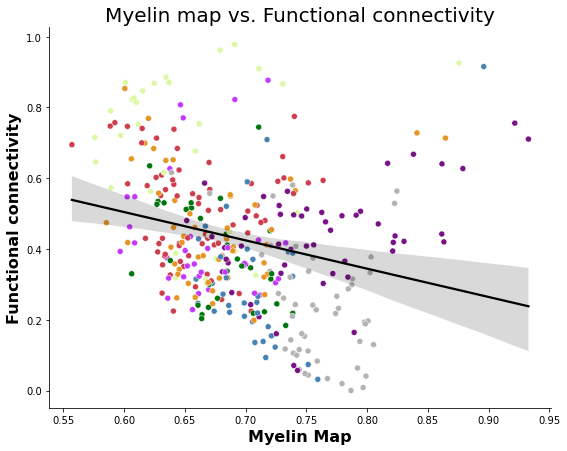

In [91]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, func_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('Myelin Map', weight='bold', fontsize=16)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)

plt.title("Myelin map vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


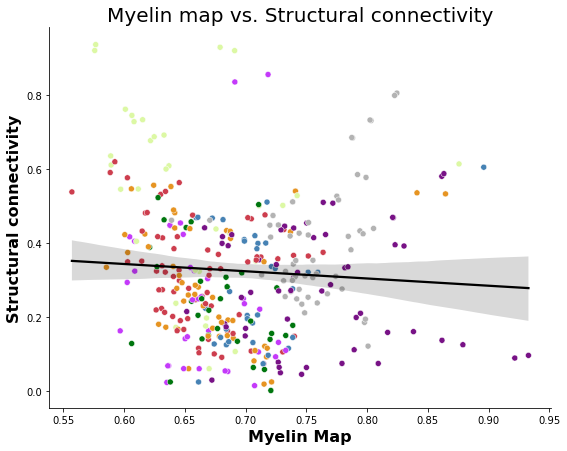

In [93]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, diff_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('Myelin Map', weight='bold', fontsize=16)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)

plt.title("Myelin map vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


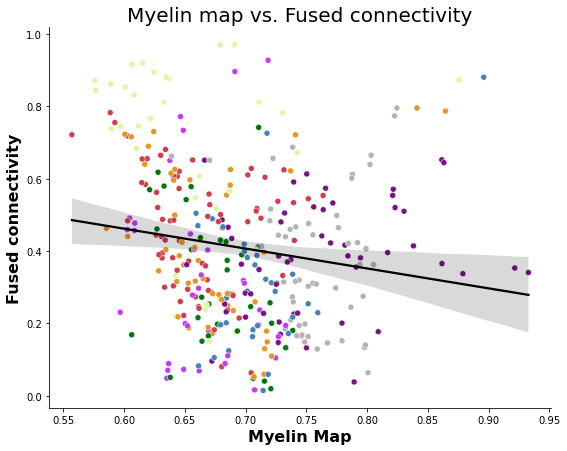

In [173]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, fused_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('Myelin Map', weight='bold', fontsize=16)
ax1.set_ylabel('Fused connectivity', weight='bold', fontsize=16)

plt.title("Myelin map vs. Fused connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=fused_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Fused_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

### Null models

In [56]:
n_perm = 10000

#### Geodesic Distance - whole brain

In [123]:
alex_geodesic_rotated = nulls.alexander_bloch(geodesic_scaled_data, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234)

In [137]:
fcgc_corr, fcgc_pval = stats.compare_images(geodesic_scaled_data,func_scaled_data, nulls=alex_geodesic_rotated)
fcgc_corr, fcgc_pval

(-0.557321576581757, 0.0403959604039596)

In [138]:
dcgc_corr, dcgc_pval = stats.compare_images(geodesic_scaled_data,diff_scaled_data, nulls=alex_geodesic_rotated)
dcgc_corr, dcgc_pval

(0.05961914058024589, 0.8742125787421258)

#### Geodesic Distance - parcellated 

In [12]:
geodesic_parc_rotated = nulls.alexander_bloch(geodesic_parc, atlas='fsaverage', density='10k',
                                n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [13]:
pc_fcgc_corr, pc_fcgc_pval = stats.compare_images(geodesic_parc,func_parc, nulls=geodesic_parc_rotated)
pc_fcgc_corr, pc_fcgc_pval

(-0.6884388576736863, 0.0072992700729927005)

In [42]:
pc_fg1_corr, pc_fg1_pval = stats.compare_images(geodesic_parc,funcG1_parc, nulls=geodesic_parc_rotated)
pc_fg1_corr, pc_fg1_pval

(0.05851917713880539, 0.8351164883511649)

In [122]:
pc_fg2_corr, pc_fg2_pval = stats.compare_images(geodesic_parc,funcG2_parc, nulls=geodesic_parc_rotated)
pc_fg2_corr, pc_fg2_pval

(0.1053556352853775, 0.5275472452754725)

In [14]:
pc_dcgc_corr, pc_dcgc_pval = stats.compare_images(geodesic_parc,diff_parc, nulls=geodesic_parc_rotated)
pc_dcgc_corr, pc_dcgc_pval

(-0.06434279955287256, 0.875012498750125)

In [43]:
pc_dg1_corr, pc_dg1_pval = stats.compare_images(geodesic_parc,diffG1_parc, nulls=geodesic_parc_rotated)
pc_dg1_corr, pc_dg1_pval

(0.5535674691200256, 0.1845815418458154)

In [31]:
pc_dg2_corr, pc_dg2_pval = stats.compare_images(geodesic_parc,diffG2_parc, nulls=geodesic_parc_rotated)
pc_dg2_corr, pc_dg2_pval

(0.25746777653694153, 0.5718428157184282)

In [133]:
pc_wrc_corr, pc_wrc_pval = stats.compare_images(geodesic_parc,wresid_parc, nulls=geodesic_parc_rotated)
pc_wrc_corr, pc_wrc_pval

(-0.250210790635736, 0.18798120187981202)

#### func G1 and diff G1 correlation difference

In [129]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [130]:
nregions = 360

In [131]:
a = geodesic_parc
b = funcG1_parc
c = diffG1_parc

In [133]:
#Bootstrap (i.e., randomly select sets of regions) and calculate correlation coefficients
nboot = 10000;
bootcorr1 = np.zeros((nboot))
bootcorr2 = np.zeros((nboot))
bootpval1 = np.zeros((nboot))
bootpval2 = np.zeros((nboot))

In [59]:
# chose pearson or spearmanr corr

In [134]:
for B in range(0,nboot):
    bootsample = np.random.randint(0, high=nregions, size=nregions);
    bootcorr1[B], bootpval1[B] = pearsonr(geodesic_parc[bootsample],funcG1_parc[bootsample])
    bootcorr2[B], bootpval2[B] = pearsonr(geodesic_parc[bootsample],diffG1_parc[bootsample])

In [135]:
# Calculate p-value based on the number of bootstraps where correlation of dmri is stronger than rfmri
bootdiff = bootcorr1-bootcorr2
pvalue = 1-(np.sum(bootdiff<0)/nboot)

In [136]:
pvalue

0.0

In [137]:
np.sum(bootdiff<0)

10000

In [138]:
boot_df = pd.DataFrame({'funcG1_geodesic_corr': bootcorr1, 'diffG1_geodesic_corr':bootcorr2}, columns=['funcG1_geodesic_corr', 'diffG1_geodesic_corr'])

In [139]:
boot_df

funcG1_geodesic_corr  diffG1_geodesic_corr
0                 0.072061              0.486081
1                 0.032445              0.516734
2                 0.068083              0.517492
3                 0.050151              0.465147
4                 0.033142              0.533835
...                    ...                   ...
9995              0.090033              0.538224
9996              0.061234              0.519622
9997              0.112701              0.549811
9998              0.083767              0.555582
9999              0.038230              0.501280

[10000 rows x 2 columns]

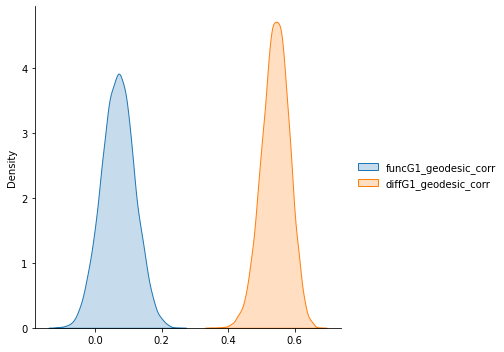

In [140]:
sns.displot(boot_df, kind="kde", fill=True)

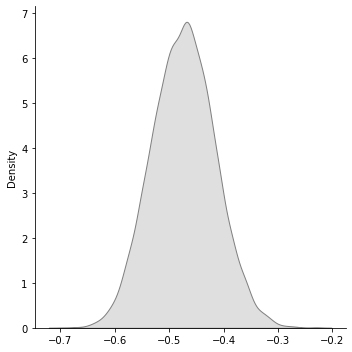

In [141]:
sns.displot(bootdiff, kind="kde", fill=True, color="grey")

In [142]:
bootdiffsort = np.sort(bootdiff);
alpha = 0.05

hi = np.floor((1-alpha/2)*nboot+.5)
lo = np.floor((alpha/2)*nboot+.5)

In [143]:
ci_high = bootdiffsort[int(hi)]
ci_low = bootdiffsort[int(lo)]

In [144]:
bootdiff.mean()

-0.47377448742558115

In [146]:
diffci = [ci_high, ci_low]
diffci

[-0.3582685871575712, -0.5847123810787171]

#### func and diff conn x geodesic correlation difference

In [15]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [26]:
nregions = 360

In [27]:
a = geodesic_parc
b = func_parc
c = diff_parc

In [28]:
#Bootstrap (i.e., randomly select sets of regions) and calculate correlation coefficients
nboot = 10000;
bootcorr1 = np.zeros((nboot))
bootcorr2 = np.zeros((nboot))
bootpval1 = np.zeros((nboot))
bootpval2 = np.zeros((nboot))

In [59]:
# chose pearson or spearmanr corr

In [29]:
for B in range(0,nboot):
    bootsample = np.random.randint(0, high=nregions, size=nregions);
    bootcorr1[B], bootpval1[B] = pearsonr(geodesic_parc[bootsample],func_parc[bootsample])
    bootcorr2[B], bootpval2[B] = pearsonr(geodesic_parc[bootsample],diff_parc[bootsample])

In [30]:
# Calculate p-value based on the number of bootstraps where correlation of dmri is stronger than rfmri
bootdiff = bootcorr1-bootcorr2
pvalue = 1-(np.sum(bootdiff<0)/nboot)

In [31]:
pvalue

0.0

In [32]:
np.sum(bootdiff<0)

10000

In [33]:
boot_df = pd.DataFrame({'func_geodesic_corr': bootcorr1, 'diff_geodesic_corr':bootcorr2}, columns=['func_geodesic_corr', 'diff_geodesic_corr'])

In [34]:
boot_df.head(5)

func_geodesic_corr  diff_geodesic_corr
0           -0.708683            0.000052
1           -0.694166           -0.025487
2           -0.703017           -0.083433
3           -0.712897           -0.038220
4           -0.704189           -0.022420

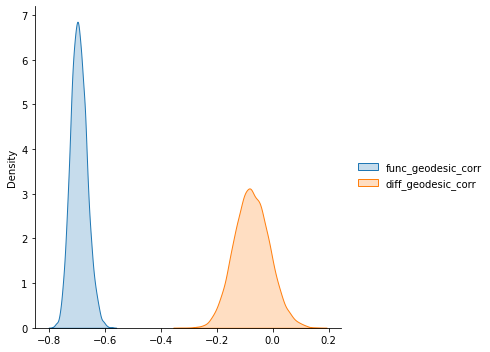

In [35]:
sns.displot(boot_df, kind="kde", fill=True)

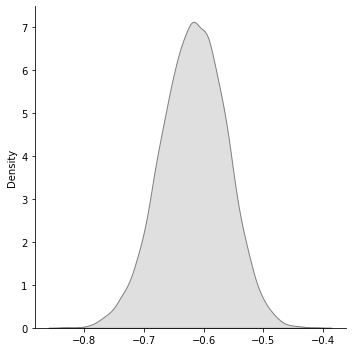

In [36]:
sns.displot(bootdiff, kind="kde", fill=True, color="grey")

In [37]:
bootdiffsort = np.sort(bootdiff);
alpha = 0.05

hi = np.floor((1-alpha/2)*nboot+.5)
lo = np.floor((alpha/2)*nboot+.5)

In [38]:
ci_high = bootdiffsort[int(hi)]
ci_low = bootdiffsort[int(lo)]

In [39]:
bootdiff.mean()

-0.6171384275186307

In [40]:
diffci = [ci_high, ci_low]
diffci

[-0.5143315719081579, -0.7274593450252343]

### Upper and lower end of G1 diff/func x Geodesic distance

In [24]:
qs = [0.05, 0.10, 0.15, 0.20, 0.25]

In [25]:
# diffusion
geod_diffG1_upplo = {}

for q in qs:
    diffG1_upp = diffG1_parc >=  np.quantile(diffG1_parc, q=(1-q))
    diffG1_lo = diffG1_parc <=  np.quantile(diffG1_parc, q=q)
    diffG1_upp_idx = np.where(diffG1_upp)[0]
    diffG1_lo_idx = np.where(diffG1_lo)[0]
    diffG1_uppGD = parc_df['geodesic'].iloc[diffG1_upp_idx]
    diffG1_loGD = parc_df['geodesic'].iloc[diffG1_lo_idx]
    diffG1_uppGD.reset_index(drop=True, inplace=True)
    diffG1_loGD.reset_index(drop=True, inplace=True)
    geod_diffG1_upplo[q] = pd.concat([diffG1_uppGD, diffG1_loGD], axis=1, ignore_index=True)
    geod_diffG1_upplo[q].columns = ['Upper','Lower']

In [26]:
# functional
geod_funcG1_upplo = {}

for q in qs:
    funcG1_upp = funcG1_parc >=  np.quantile(funcG1_parc, q=(1-q))
    funcG1_lo = funcG1_parc <=  np.quantile(funcG1_parc, q=q)
    funcG1_upp_idx = np.where(funcG1_upp)[0]
    funcG1_lo_idx = np.where(funcG1_lo)[0]
    funcG1_uppGD = parc_df['geodesic'].iloc[funcG1_upp_idx]
    funcG1_loGD = parc_df['geodesic'].iloc[funcG1_lo_idx]
    funcG1_uppGD.reset_index(drop=True, inplace=True)
    funcG1_loGD.reset_index(drop=True, inplace=True)
    geod_funcG1_upplo[q] = pd.concat([funcG1_uppGD, funcG1_loGD], axis=1, ignore_index=True)
    geod_funcG1_upplo[q].columns = ['Upper','Lower']

In [64]:
geod_funcG1_upplo[0.05].head(5)

Upper     Lower
0  0.448139  0.727200
1  0.465880  0.638180
2  0.303385  0.653766
3  0.229852  0.697980
4  0.375998  0.261173

#### plots

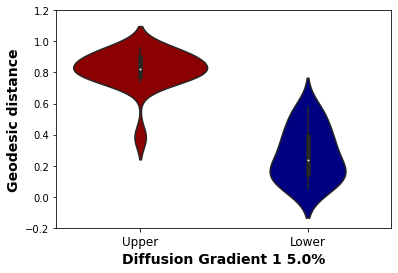

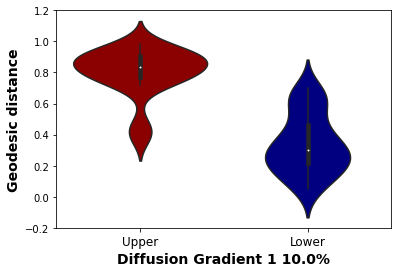

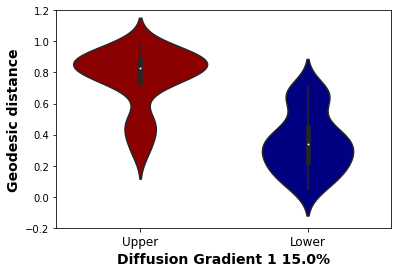

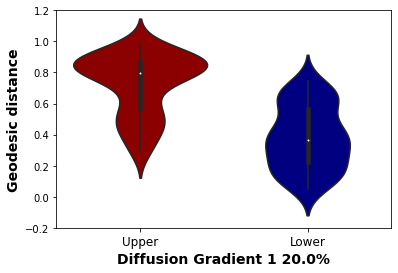

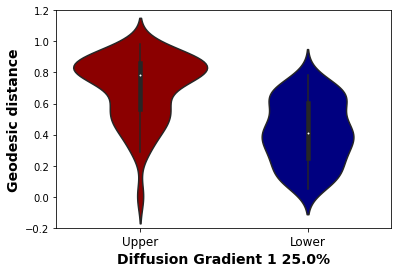

In [37]:
for q in qs:
    fig, ax = plt.subplots()
    ax = sns.violinplot(data=geod_diffG1_upplo[q], palette=['darkred', 'navy'], saturation=1.0)
    plt.ylim(-0.2, 1.2)
    plt.ylabel('Geodesic distance', size=14, weight=900)
    plt.xticks(size=12)
    plt.xlabel(f'Diffusion Gradient 1 '+str(q*100)+'%', size=14, weight=900)
    plt.savefig(fig_path+f'Diff_7Tsubj_geodesic_G1-'+str(q*100)+'%.png', dpi=300, bbox_inches='tight')
    plt.show

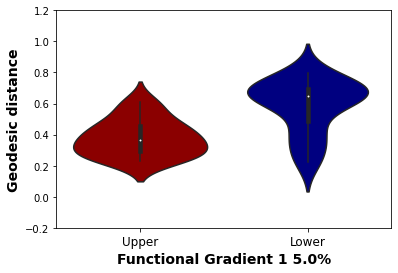

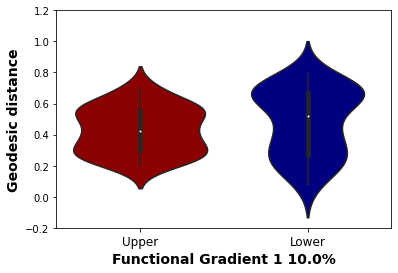

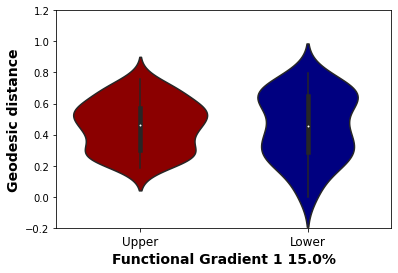

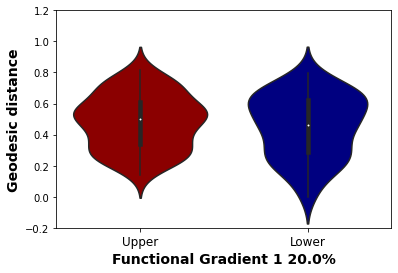

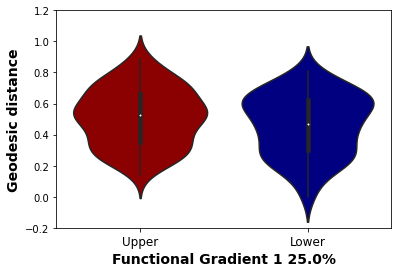

In [38]:
for q in qs:
    fig, ax = plt.subplots()
    ax = sns.violinplot(data=geod_funcG1_upplo[q], palette=['darkred', 'navy'], saturation=1.0)
    plt.ylim(-0.2, 1.2)
    plt.ylabel('Geodesic distance', size=14, weight=900)
    plt.xticks(size=12)
    plt.xlabel(f'Functional Gradient 1 '+str(q*100)+'%', size=14, weight=900)
    plt.savefig(fig_path+f'Func_HCPMMP_geodesic_G1-'+str(q*100)+'%.png', dpi=300, bbox_inches='tight')
    plt.show

#### stats in different tresholds

In [80]:
from pingouin import ttest
ttestr = {}
diffttest_df = pd.DataFrame(columns = ['T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10', 'power'])
for q in qs:
    Upper = geod_diffG1_upplo[q]["Upper"].to_numpy()
    Lower = geod_diffG1_upplo[q]["Lower"].to_numpy()
    ttestr[q] = ttest(Upper, Lower, paired=False)
    diffttest_df =  pd.concat([diffttest_df, ttestr[q]])
diffttest_df.index=qs

In [81]:
diffttest_df

T  dof alternative         p-val         CI95%   cohen-d  \
0.05  11.078983   34   two-sided  7.938190e-13  [0.45, 0.65]  3.692994   
0.10  11.336671   70   two-sided  1.676112e-17  [0.38, 0.54]  2.672079   
0.15  11.068096  106   two-sided  2.188706e-19  [0.34, 0.48]  2.130056   
0.20  10.427662  142   two-sided  2.955761e-19  [0.28, 0.41]  1.737944   
0.25   9.281110  178   two-sided  5.739451e-17  [0.23, 0.35]  1.383546   

           BF10  power  
0.05   5.77e+09    1.0  
0.10  2.118e+14    1.0  
0.15  1.556e+16    1.0  
0.20  1.237e+16    1.0  
0.25  7.822e+13    1.0

In [82]:
ttestr = {}
functtest_df = pd.DataFrame(columns = ['T', 'dof', 'alternative', 'p-val', 'CI95%', 'cohen-d', 'BF10', 'power'], dtype='object')
for q in qs:
    Upper = geod_funcG1_upplo[q]["Upper"].to_numpy()
    Lower = geod_funcG1_upplo[q]["Lower"].to_numpy()
    ttestr[q] = ttest(Upper, Lower, paired=False)
    functtest_df =  pd.concat([functtest_df, ttestr[q]])
functtest_df.index=qs

In [83]:
functtest_df

T  dof alternative     p-val           CI95%   cohen-d     BF10  \
0.05 -4.249391   34   two-sided  0.000158  [-0.31, -0.11]  1.416464  145.375   
0.10 -1.295309   70   two-sided  0.199469   [-0.14, 0.03]  0.305307    0.498   
0.15  0.246496  106   two-sided  0.805775   [-0.06, 0.08]  0.047438    0.209   
0.20  0.908380  142   two-sided  0.365217   [-0.03, 0.09]  0.151397    0.261   
0.25  1.717352  178   two-sided  0.087654   [-0.01, 0.11]  0.256008    0.633   

         power  
0.05  0.984868  
0.10  0.248098  
0.15  0.056863  
0.20  0.147196  
0.25  0.400690

### Neuromaps (VAChT)

#### loading data

In [10]:
Aghourian_FEOBV = datasets.fetch_annotation(source='aghourian2017', desc='feobv')
print(Aghourian_FEOBV)
Bedard_FEOBV = datasets.fetch_annotation(source='bedard2019', desc='feobv')
print(Bedard_FEOBV)
Tuominen_FEOBV = datasets.fetch_annotation(source='tuominen', desc='feobv')
print(Tuominen_FEOBV)

/home/ROBARTS/schakraborty/neuromaps-data/annotations/aghourian2017/feobv/MNI152/source-aghourian2017_desc-feobv_space-MNI152_res-1mm_feature.nii.gz
/home/ROBARTS/schakraborty/neuromaps-data/annotations/bedard2019/feobv/MNI152/source-bedard2019_desc-feobv_space-MNI152_res-1mm_feature.nii.gz
/home/ROBARTS/schakraborty/neuromaps-data/annotations/tuominen/feobv/MNI152/source-tuominen_desc-feobv_space-MNI152_res-2mm_feature.nii.gz


In [11]:
from neuromaps import transforms
Aghourian_FEOBV_fsa = transforms.mni152_to_fsaverage(Aghourian_FEOBV, '10k')
Bedard_FEOBV_fsa = transforms.mni152_to_fsaverage(Bedard_FEOBV, '10k')
Tuominen_FEOBV_fsa = transforms.mni152_to_fsaverage(Tuominen_FEOBV, '10k')

In [12]:
Aghourian_FEOBV_fsa_lh, Aghourian_FEOBV_fsa_rh = Aghourian_FEOBV_fsa
Aghourian_FEOBV_fsa_lh_data = Aghourian_FEOBV_fsa_lh.agg_data()
Aghourian_FEOBV_fsa_rh_data = Aghourian_FEOBV_fsa_rh.agg_data()
Aghourian_FEOBV_fsa_data = np.concatenate((Aghourian_FEOBV_fsa_lh_data, Aghourian_FEOBV_fsa_rh_data))

In [13]:
Bedard_FEOBV_fsa_lh, Bedard_FEOBV_fsa_rh = Bedard_FEOBV_fsa
Bedard_FEOBV_fsa_lh_data = Bedard_FEOBV_fsa_lh.agg_data()
Bedard_FEOBV_fsa_rh_data = Bedard_FEOBV_fsa_rh.agg_data()
Bedard_FEOBV_fsa_data = np.concatenate((Bedard_FEOBV_fsa_lh_data, Bedard_FEOBV_fsa_rh_data))

In [14]:
Tuominen_FEOBV_fsa_lh, Tuominen_FEOBV_fsa_rh = Tuominen_FEOBV_fsa
Tuominen_FEOBV_fsa_lh_data = Tuominen_FEOBV_fsa_lh.agg_data()
Tuominen_FEOBV_fsa_rh_data = Tuominen_FEOBV_fsa_rh.agg_data()
Tuominen_FEOBV_fsa_data = np.concatenate((Tuominen_FEOBV_fsa_lh_data, Tuominen_FEOBV_fsa_rh_data))

#### Michigan Data load

In [5]:
mic_uncorr = nib.load(data_path+f't2a_wProject_TWS_001_FEOBV_wac_1-13.nii')
mic_corr = nib.load(data_path+f't2a_wProject_TWS_001_FEOBV_pvcwac_1-13.nii')

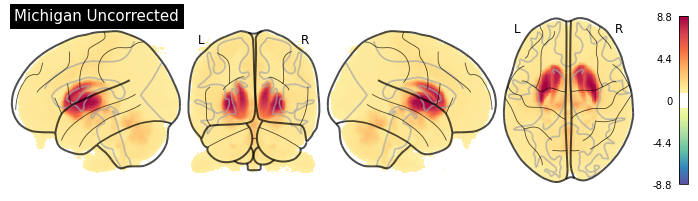

In [6]:
import matplotlib.cm
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
niifile = mic_uncorr
color = matplotlib.cm.get_cmap('Spectral_r')
plot_glass_brain(niifile, colorbar=True, title=("Michigan Uncorrected"), display_mode='lyrz', plot_abs=False, cmap=color)

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


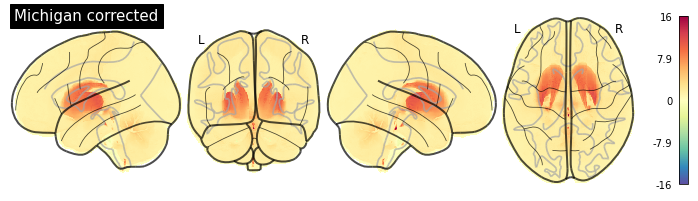

In [63]:
niifile = mic_corr
color = matplotlib.cm.get_cmap('Spectral_r')
plot_glass_brain(niifile, colorbar=True, title=("Michigan corrected"), display_mode='lyrz', plot_abs=False, cmap=color)

In [7]:
from neuromaps import transforms
mic_uncorr_fsa = transforms.mni152_to_fsaverage(mic_uncorr, '10k')
mic_corr_fsa = transforms.mni152_to_fsaverage(mic_corr, '10k')

In [8]:
mic_uncorr_fsa_lh, mic_uncorr_fsa_rh = mic_uncorr_fsa
mic_uncorr_fsa_lh_data = mic_uncorr_fsa_lh.agg_data()
mic_uncorr_fsa_rh_data = mic_uncorr_fsa_rh.agg_data()
mic_uncorr_data = np.concatenate((mic_uncorr_fsa_lh_data, mic_uncorr_fsa_rh_data))

In [9]:
mic_corr_fsa_lh, mic_corr_fsa_rh = mic_corr_fsa
mic_corr_fsa_lh_data = mic_corr_fsa_lh.agg_data()
mic_corr_fsa_rh_data = mic_corr_fsa_rh.agg_data()
mic_corr_data = np.concatenate((mic_corr_fsa_lh_data, mic_corr_fsa_rh_data))

/tmp/ipykernel_11645/4037074994.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


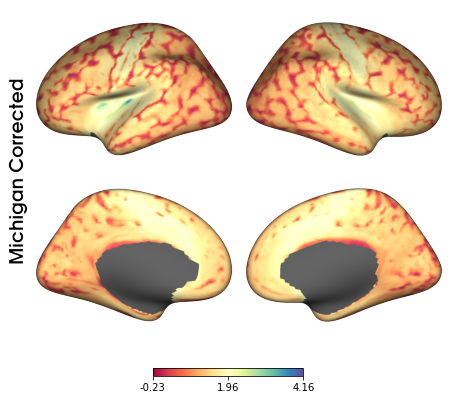

In [42]:
from neuromaps.datasets import fetch_fsaverage
from surfplot import Plot
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

med_lh, med_rh = surfaces['medial']
# get medial wall gifti - array for masking the data
med_lh_img = images.load_gifti(med_lh)
med_lh_data = med_lh_img.agg_data()
med_rh_img = images.load_gifti(med_rh)
med_rh_data = med_rh_img.agg_data()

# mask the medial wall first 
mic_uncorr_fsa_lh_data[np.logical_not(med_lh_data)] = 0
mic_uncorr_fsa_rh_data[np.logical_not(med_rh_data)] = 0
mic_corr_fsa_lh_data[np.logical_not(med_lh_data)] = 0
mic_corr_fsa_rh_data[np.logical_not(med_rh_data)] = 0

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Michigan Corrected']}, brightness=.8)
#p.add_layer({'left': mic_uncorr_fsa_lh_data, 'right': mic_uncorr_fsa_rh_data}, cmap='Spectral', cbar=True)
p.add_layer({'left': mic_corr_fsa_lh_data, 'right': mic_corr_fsa_rh_data}, cmap='Spectral', cbar=True)
fig = p.build()
fig.show()

#### visualize 

/tmp/ipykernel_987364/3785704217.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


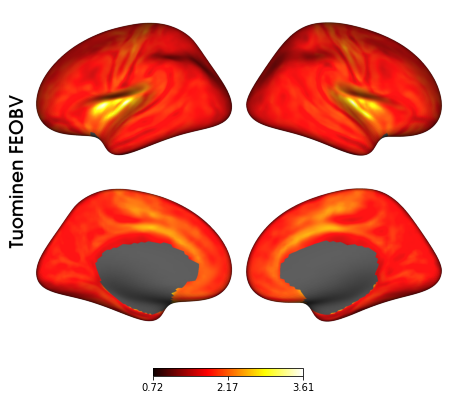

In [91]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

med_lh, med_rh = surfaces['medial']
# get medial wall gifti - array for masking the data
med_lh_img = images.load_gifti(med_lh)
med_lh_data = med_lh_img.agg_data()
med_rh_img = images.load_gifti(med_rh)
med_rh_data = med_rh_img.agg_data()

# mask the medial wall first 
Aghourian_FEOBV_fsa_lh_data[np.logical_not(med_lh_data)] = 0
Aghourian_FEOBV_fsa_rh_data[np.logical_not(med_rh_data)] = 0
Bedard_FEOBV_fsa_lh_data[np.logical_not(med_lh_data)] = 0
Bedard_FEOBV_fsa_rh_data[np.logical_not(med_rh_data)] = 0
Tuominen_FEOBV_fsa_lh_data[np.logical_not(med_lh_data)] = 0
Tuominen_FEOBV_fsa_rh_data[np.logical_not(med_rh_data)] = 0

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Tuominen FEOBV']}, brightness=.8)
#p.add_layer({'left': Aghourian_FEOBV_fsa_lh_data, 'right': Aghourian_FEOBV_fsa_rh_data}, cmap='hsv', cbar=True)
#p.add_layer({'left': Bedard_FEOBV_fsa_lh_data, 'right': Bedard_FEOBV_fsa_rh_data}, cmap='hsv', cbar=True)
p.add_layer({'left': Tuominen_FEOBV_fsa_lh_data, 'right': Tuominen_FEOBV_fsa_rh_data}, cmap='hot', cbar=True)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_orig_Tuominen_FEOBV_inflated_grid.png', dpi=300)

#### rescale and visualize

In [19]:
Aghourian_FEOBV_fsa_data = np.concatenate((Aghourian_FEOBV_fsa_lh_data, Aghourian_FEOBV_fsa_rh_data))
Bedard_FEOBV_fsa_data = np.concatenate((Bedard_FEOBV_fsa_lh_data, Bedard_FEOBV_fsa_rh_data))
Tuominen_FEOBV_fsa_data = np.concatenate((Tuominen_FEOBV_fsa_lh_data, Tuominen_FEOBV_fsa_rh_data))

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
Aghourian_scaled_data = min_max_scaler.fit_transform(Aghourian_FEOBV_fsa_data.reshape(-1, 1))
Bedard_scaled_data = min_max_scaler.fit_transform(Bedard_FEOBV_fsa_data.reshape(-1, 1))
Tuominen_scaled_data = min_max_scaler.fit_transform(Tuominen_FEOBV_fsa_data.reshape(-1, 1))

In [28]:
#mic_uncorr_fsa_data = np.concatenate((mic_uncorr_fsa_lh_data, mic_uncorr_fsa_rh_data))
#mic_corr_fsa_data = np.concatenate((mic_corr_fsa_lh_data, mic_corr_fsa_rh_data))

In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
mic_uncorr_scaled_data = min_max_scaler.fit_transform(mic_uncorr_data.reshape(-1, 1))
mic_corr_scaled_data = min_max_scaler.fit_transform(mic_corr_data.reshape(-1, 1))

/tmp/ipykernel_25229/11072429.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


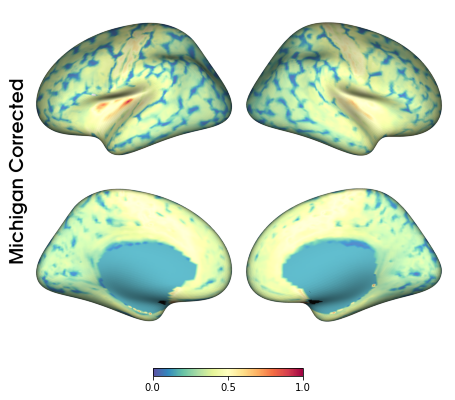

In [68]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Michigan Corrected']}, brightness=.8)
#p.add_layer(Aghourian_scaled_data.reshape([20484]), cmap='hot', cbar=True, color_range=[0,1])
#p.add_layer(Bedard_scaled_data.reshape([20484]), cmap='hot', cbar=True, color_range=[0,1])
#p.add_layer(Tuominen_scaled_data.reshape([20484]), cmap='hot', cbar=True, color_range=[0,1])
#p.add_layer(mic_uncorr_scaled_data.reshape([20484]), cmap='Spectral', cbar=True, color_range=[0,1])
p.add_layer(mic_corr_scaled_data.reshape([20484]), cmap='Spectral_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'wholebrain_scaled_Michigan_FEOBV_inflated_grid.png', dpi=300)

#### parcellate VAChT maps

In [15]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')

In [16]:
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

In [17]:
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [21]:
Aghourian_parc = hcpmmp.transform(Aghourian_scaled_data.reshape([20484]), 'fsaverage', ignore_background_data=True)
Bedard_parc = hcpmmp.transform(Bedard_scaled_data.reshape([20484]), 'fsaverage', ignore_background_data=True)
Tuominen_parc = hcpmmp.transform(Tuominen_scaled_data.reshape([20484]), 'fsaverage', ignore_background_data=True)

In [15]:
MicUnc_parc = hcpmmp.transform(mic_uncorr_scaled_data.reshape([20484]), 'fsaverage', ignore_background_data=True)
MicCorr_parc = hcpmmp.transform(mic_corr_scaled_data.reshape([20484]), 'fsaverage', ignore_background_data=True)

In [22]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [23]:
Aghourian_parc_cortex = map_to_labels(Aghourian_parc,surf_labels, mask=mask, fill=np.nan)
Bedard_parc_cortex = map_to_labels(Bedard_parc,surf_labels, mask=mask, fill=np.nan)
Tuominen_parc_cortex = map_to_labels(Tuominen_parc,surf_labels, mask=mask, fill=np.nan)

In [17]:
MicUnc_parc_cortex = map_to_labels(MicUnc_parc,surf_labels, mask=mask, fill=np.nan)
MicCorr_parc_cortex = map_to_labels(MicCorr_parc,surf_labels, mask=mask, fill=np.nan)

/tmp/ipykernel_30769/100523548.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


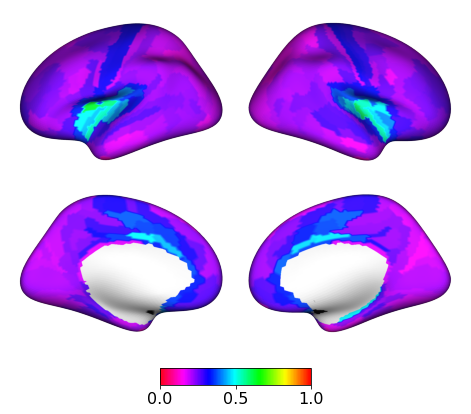

In [26]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)
# label_text={'left':['Michigan FEOBV']},
#p.add_layer(Aghourian_parc_cortex, cmap='hsv_r', cbar=True, color_range=[0,1])
#p.add_layer(Bedard_parc_cortex, cmap='hsv_r', cbar=True, color_range=[0,1])
p.add_layer(Tuominen_parc_cortex, cmap='hsv_r', cbar=True, color_range=[0,1])
#p.add_layer(MicUnc_parc_cortex, cmap='Spectral', cbar=True, color_range=[0,1])
#p.add_layer(MicCorr_parc_cortex, cmap='hsv_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
fig.savefig(fig_path+'parc_scaled_Tuominen_FEOBV_inflated_grid_hsv-r.png', dpi=300)

#### geodesic x scatter plot

##### WholeBrain

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


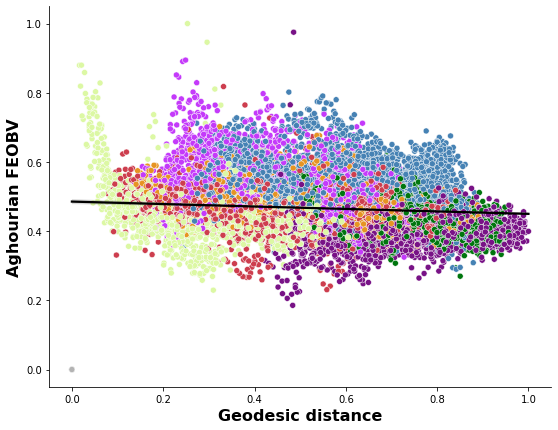

In [113]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_scaled_data, Aghourian_scaled_data.reshape([20484]), hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Aghourian_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_scaled_data,
    y=Aghourian_scaled_data.reshape([20484]),
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'wholebrain_Geodesic_distance_vs_Aghourian_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


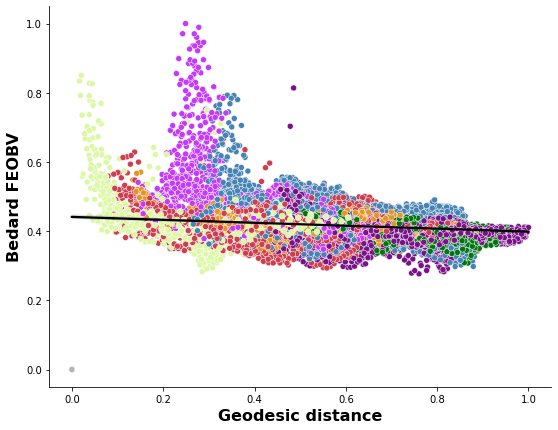

In [112]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_scaled_data, Bedard_scaled_data.reshape([20484]), hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Bedard_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_scaled_data,
    y=Bedard_scaled_data.reshape([20484]),
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'wholebrain_Geodesic_distance_vs_Bedard_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


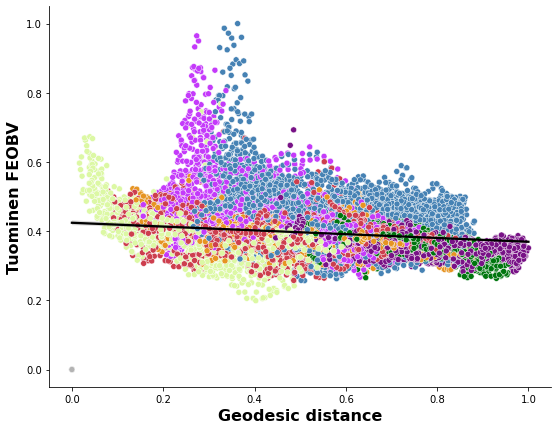

In [114]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_scaled_data, Tuominen_scaled_data.reshape([20484]), hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_scaled_data,
    y=Tuominen_scaled_data.reshape([20484]),
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'wholebrain_Geodesic_distance_vs_Tuominen_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

#####  Parcellated brain

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


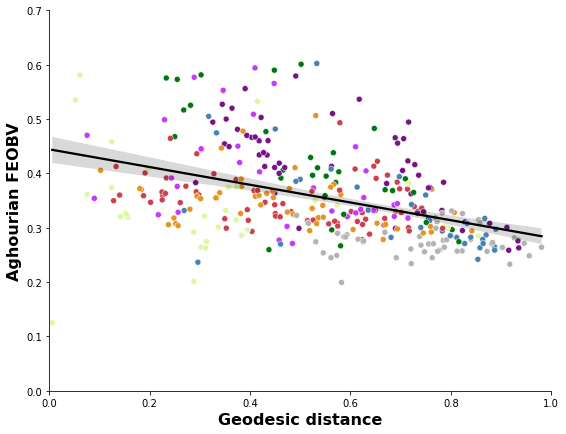

In [28]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Aghourian_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Aghourian_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Aghourian_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Aghourian_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


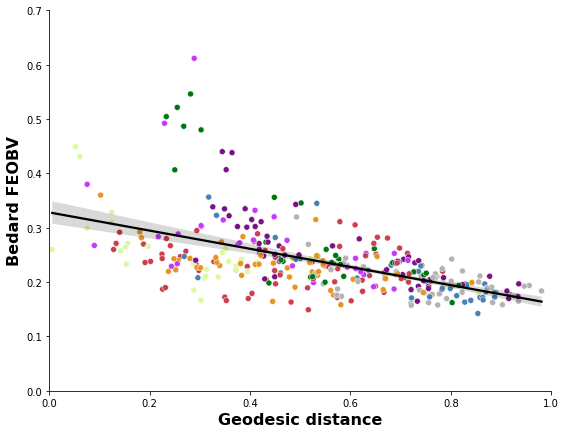

In [29]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Bedard_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Bedard_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Bedard_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Bedard_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


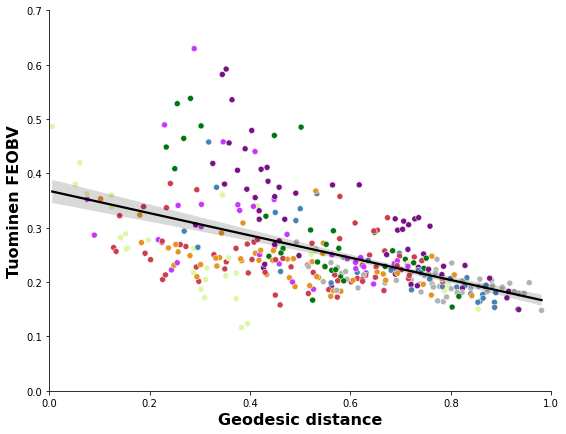

In [31]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Tuominen_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Tuominen_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Tuominen_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


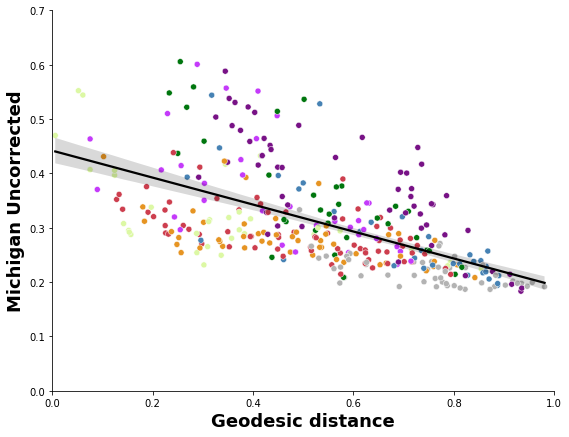

In [96]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, MicUnc_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax1.set_ylabel('Michigan Uncorrected', weight='bold', fontsize=18)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=MicUnc_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Michigan-Uncorrected_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


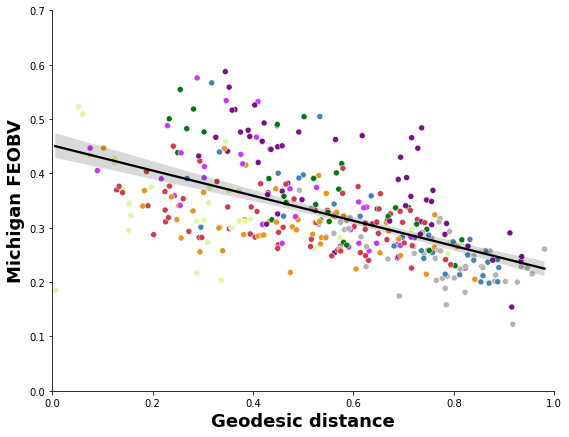

In [97]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, MicCorr_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax1.set_ylabel('Michigan FEOBV', weight='bold', fontsize=18)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=MicCorr_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Michigan-Corrected_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


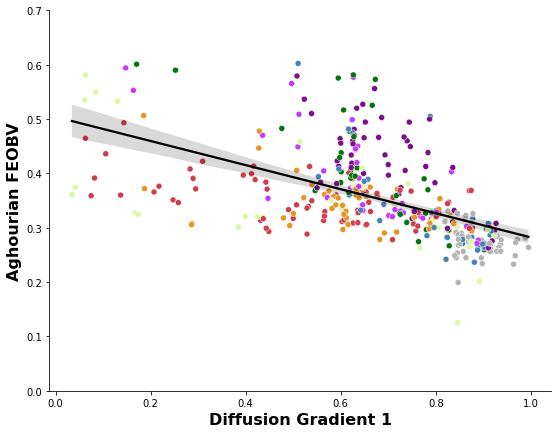

In [35]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(diffG1_parc, Aghourian_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Diffusion Gradient 1', weight='bold', fontsize=16)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=diffG1_parc,
    y=Aghourian_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Diffusion-G1_vs_Aghourian_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


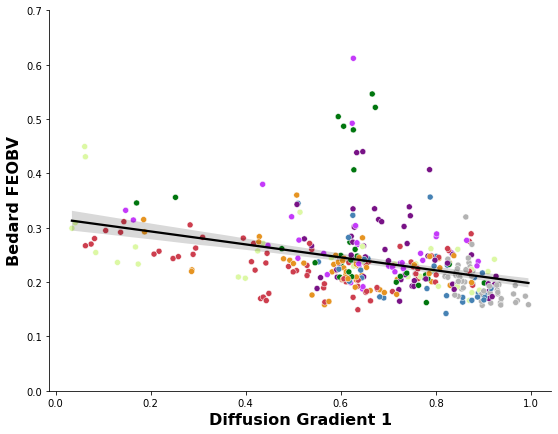

In [36]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(diffG1_parc, Bedard_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Diffusion Gradient 1', weight='bold', fontsize=16)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=diffG1_parc,
    y=Bedard_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Diffusion-G1_vs_Bedard_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


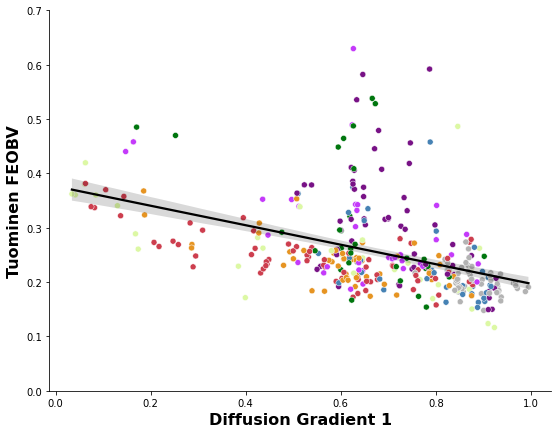

In [34]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(diffG1_parc, Tuominen_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Diffusion Gradient 1', weight='bold', fontsize=16)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=diffG1_parc,
    y=Tuominen_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Diffusion-G1_vs_Tuominen_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

#### Geodesic x Spin test

In [57]:
n_perm = 10000

In [118]:
# Whole brain

In [123]:
alex_geodesic_rotated = nulls.alexander_bloch(geodesic_scaled_data, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234)

In [164]:
afgc_corr, afgc_pval = stats.compare_images(geodesic_scaled_data, Aghourian_scaled_data.reshape([20484]), nulls=alex_geodesic_rotated)
afgc_corr, afgc_pval

(-0.3282221023626283, 0.19858014198580143)

In [165]:
bfgc_corr, bfgc_pval = stats.compare_images(geodesic_scaled_data, Bedard_scaled_data.reshape([20484]), nulls=alex_geodesic_rotated)
bfgc_corr, bfgc_pval

(-0.46641433940443655, 0.0038996100389961006)

In [166]:
tfgc_corr, tfgc_pval = stats.compare_images(geodesic_scaled_data, Tuominen_scaled_data.reshape([20484]), nulls=alex_geodesic_rotated)
tfgc_corr, tfgc_pval

(-0.39722524451984575, 0.0006999300069993001)

In [40]:
alex_diffG1_rotated = nulls.alexander_bloch(diffG1_scaled_data, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234)

In [41]:
afdg1_corr, afdg1_pval = stats.compare_images(diffG1_scaled_data, Aghourian_scaled_data.reshape([20484]), nulls=alex_diffG1_rotated)
afdg1_corr, afdg1_pval

(-0.45141774515896876, 0.0016998300169983002)

In [42]:
bfdg1_corr, bfdg1_pval = stats.compare_images(diffG1_scaled_data, Bedard_scaled_data.reshape([20484]), nulls=alex_diffG1_rotated)
bfdg1_corr, bfdg1_pval

(-0.31231085851324514, 0.08649135086491351)

In [43]:
tfdg1_corr, tfdg1_pval = stats.compare_images(diffG1_scaled_data, Tuominen_scaled_data.reshape([20484]), nulls=alex_diffG1_rotated)
tfdg1_corr, tfdg1_pval

(-0.36674306859452815, 0.008599140085991401)

In [58]:
# Parcellated data spin test
geodesic_parc_rotated = nulls.alexander_bloch(geodesic_parc, atlas='fsaverage', density='10k',
                                n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [44]:
pc_afgc_corr, pc_afgc_pval = stats.compare_images(geodesic_parc, Aghourian_parc, nulls=geodesic_parc_rotated)
pc_afgc_corr, pc_afgc_pval

(-0.4276522696018219, 0.11848815118488151)

In [45]:
pc_bfgc_corr, pc_bfgc_pval = stats.compare_images(geodesic_parc, Bedard_parc, nulls=geodesic_parc_rotated)
pc_bfgc_corr, pc_bfgc_pval

(-0.5590590238571167, 0.0052994700529947)

In [46]:
pc_tfgc_corr, pc_tfgc_pval = stats.compare_images(geodesic_parc, Tuominen_parc, nulls=geodesic_parc_rotated)
pc_tfgc_corr, pc_tfgc_pval

(-0.5375537276268005, 0.00019998000199980003)

In [59]:
pc_mugc_corr, pc_mugc_pval = stats.compare_images(geodesic_parc, MicUnc_parc, nulls=geodesic_parc_rotated)
pc_mugc_corr, pc_mugc_pval

(-0.5921834464994131, 0.0004999500049995)

In [60]:
pc_mcgc_corr, pc_mcgc_pval = stats.compare_images(geodesic_parc, MicCorr_parc, nulls=geodesic_parc_rotated)
pc_mcgc_corr, pc_mcgc_pval

(-0.5854330551791095, 0.00019998000199980003)

In [44]:
diffG1_parc_rotated = nulls.alexander_bloch(diffG1_parc, atlas='fsaverage', density='10k',
                                              n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [45]:
pc_afdg1_corr, pc_afdg1_pval = stats.compare_images(diffG1_parc, Aghourian_parc, nulls=diffG1_parc_rotated)
pc_afdg1_corr, pc_afdg1_pval

(-0.5544192837347244, 0.0052994700529947)

In [46]:
pc_bfdg1_corr, pc_bfdg1_pval = stats.compare_images(diffG1_parc, Bedard_parc, nulls=diffG1_parc_rotated)
pc_bfdg1_corr, pc_bfdg1_pval

(-0.3801590770894699, 0.07979202079792021)

In [47]:
pc_tfdg1_corr, pc_tfdg1_pval = stats.compare_images(diffG1_parc, Tuominen_parc, nulls=diffG1_parc_rotated)
pc_tfdg1_corr, pc_tfdg1_pval

(-0.4483480251285871, 0.0165983401659834)

#### weighted cortical residual map x Spin test

In [68]:
# Parcellated data spin test
wresid_parc_rotated = nulls.alexander_bloch(wresid_parc, atlas='fsaverage', density='10k',
                                            n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [162]:
pc_afwc_corr, pc_afwc_pval = stats.compare_images(wresid_parc, Aghourian_parc, nulls=wresid_parc_rotated)
pc_afwc_corr, pc_afwc_pval

(0.33188246393552406, 0.0024997500249975004)

In [163]:
pc_bfwc_corr, pc_bfwc_pval = stats.compare_images(wresid_parc, Bedard_parc, nulls=wresid_parc_rotated)
pc_bfwc_corr, pc_bfwc_pval

(0.29267129826437216, 0.012798720127987202)

In [164]:
pc_tfwc_corr, pc_tfwc_pval = stats.compare_images(wresid_parc, Tuominen_parc, nulls=wresid_parc_rotated)
pc_tfwc_corr, pc_tfwc_pval

(0.2573830378425152, 0.0287971202879712)

In [69]:
pc_muwc_corr, pc_muwc_pval = stats.compare_images(wresid_parc, MicUnc_parc, nulls=wresid_parc_rotated)
pc_muwc_corr, pc_muwc_pval

(0.2785920663562592, 0.022397760223977603)

In [70]:
pc_mcwc_corr, pc_mcwc_pval = stats.compare_images(wresid_parc, MicCorr_parc, nulls=wresid_parc_rotated)
pc_mcwc_corr, pc_mcwc_pval

(0.2822861435562684, 0.019698030196980302)

### BF segment relation

In [42]:
bf_label = pd.read_csv(Diff_results + 'Diff_7Tsubj_grad-atlaslabels.csv')

In [39]:
Diff_GCtx = np.load(Diff_results + 'Diff_7Tsubj_Gradient-weighted_CorticalConnectivity.npz')
Diff_GCtx.files

['G1_Ctx', 'G2_Ctx', 'G3_Ctx', 'G4_Ctx', 'G5_Ctx', 'G6_Ctx']

In [63]:
diff_g1 = Diff_GCtx['G1_Ctx']
diff_g1

array([[ 1.56482958e+00,  3.47564825e-01,  8.60921136e-01, ...,
         5.70035035e-01,  1.01160149e-01,  3.34560062e-01],
       [ 1.70980229e+00,  3.92016590e-01,  9.15272048e-01, ...,
         7.28656321e-01,  1.12175410e-01,  2.72257747e-01],
       [ 1.67316130e+00,  4.61911600e-01,  9.81982361e-01, ...,
         7.80027371e-01,  9.78286110e-02,  3.42692450e-01],
       ...,
       [ 9.38677416e-02,  2.11845164e-02,  5.44458142e-02, ...,
         3.52344985e-02,  2.59924552e-02,  5.97788024e-02],
       [-1.02103353e-02, -8.60252724e-04, -4.55101998e-03, ...,
        -2.73823255e-03, -4.87736435e-03, -7.24623990e-03],
       [ 1.59507767e+00,  3.55424903e-01,  9.14532849e-01, ...,
         6.40924336e-01,  8.50149419e-02,  2.98841130e-01]])

In [65]:
min_max_scaler = preprocessing.MinMaxScaler()
diff_scaled_g1 = min_max_scaler.fit_transform(diff_g1)

(599, 360)

In [67]:
diff_scaled_g1.max()

1.0000000000000002

In [52]:
bf = bf_label['labels']
bf.shape

(599,)

In [78]:
diff_g1_ch123 = diff_g1[bf == 1, :]
diff_g1_ch123

array([[-0.76089749, -0.09455868, -0.33147135, ..., -0.23039011,
        -0.1949281 , -0.77406968],
       [-0.69155752, -0.05738603, -0.26062854, ..., -0.18091645,
        -0.18727351, -0.76285332],
       [-0.65409577, -0.04504208, -0.23815029, ..., -0.14823598,
        -0.14365343, -0.6748966 ],
       ...,
       [-0.59606903, -0.03616111, -0.25843886, ..., -0.1579783 ,
        -0.12100626, -0.61075967],
       [-0.67686054, -0.06719442, -0.29096206, ..., -0.2304062 ,
        -0.18496147, -0.75535436],
       [-0.60857739, -0.04599615, -0.2565261 , ..., -0.18185973,
        -0.12091148, -0.58656901]])

In [79]:
diff_g1_ch4 = diff_g1[bf == 2, :]
diff_g1_ch4.shape

(369, 360)

In [80]:
diff_g1_ch4p = diff_g1[bf == 3, :]
diff_g1_ch4p.shape

(36, 360)

In [81]:
diff_g1_ch123_ctx = np.nanmean(diff_g1_ch123,axis=0).reshape([360,1])
diff_g1_ch4_ctx = np.nanmean(diff_g1_ch4,axis=0).reshape([360,1])
diff_g1_ch4p_ctx = np.nanmean(diff_g1_ch4p,axis=0).reshape([360,1])

In [72]:
diff_g1_ch123_ctx.shape

(360, 1)

In [82]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [83]:
diffG1Ch123 = map_to_labels(diff_g1_ch123_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
diffG1Ch4 = map_to_labels(diff_g1_ch4_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
diffG1Ch4p = map_to_labels(diff_g1_ch4p_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [84]:
diffG1Ch123

array([-0.24498032, -0.13129904, -0.13022638, ..., -0.17058456,
       -0.17058456, -0.17058456])

In [85]:
df = pd.DataFrame(
    dict(
        ch123=diffG1Ch123,
        ch4=diffG1Ch4,
        ch4p=diffG1Ch4p
    )
)

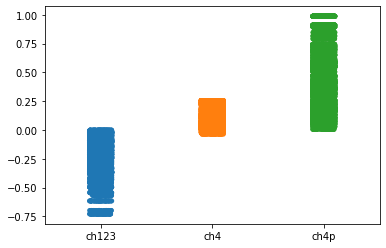

In [86]:
ax = sns.stripplot(data=df)

Text(0, 0.5, 'Ch4')

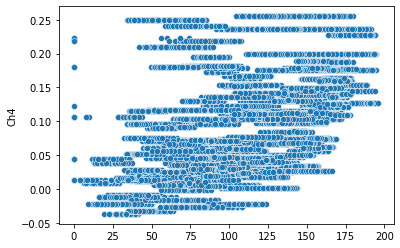

In [99]:
sns.scatterplot(x=geodesic_data,y=diffG1Ch4)
plt.ylabel('Ch4')

Text(0, 0.5, 'Ch123')

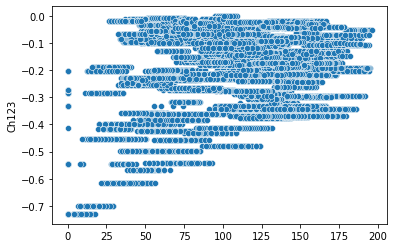

In [98]:
sns.scatterplot(x=geodesic_data,y=diffG1Ch123)
plt.ylabel('Ch123')

### Myelin Map stats

#### Myelin map - whole brain

In [139]:
alex_myelin_rotated = nulls.alexander_bloch(myelin_scaled_data, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234)

In [140]:
fcmc_corr, fcmc_pval = stats.compare_images(myelin_scaled_data,func_scaled_data, nulls=alex_myelin_rotated)
fcmc_corr, fcmc_pval

(-0.15758198255713743, 0.49245075492450757)

In [141]:
dcmc_corr, dcmc_pval = stats.compare_images(myelin_scaled_data,diff_scaled_data, nulls=alex_myelin_rotated)
dcmc_corr, dcmc_pval

(0.17519938575875313, 0.35936406359364065)

#### Myelin map - parcellated data

In [139]:
myelin_parc_rotated = nulls.alexander_bloch(myelin_parc, atlas='fsaverage', density='10k',
                                n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [103]:
pc_fcmc_corr, pc_fcmc_pval = stats.compare_images(myelin_parc,func_parc, nulls=myelin_parc_rotated)
pc_fcmc_corr, pc_fcmc_pval

(-0.25655806064605713, 0.20767923207679231)

In [104]:
pc_dcmc_corr, pc_dcmc_pval = stats.compare_images(myelin_parc,diff_parc, nulls=myelin_parc_rotated)
pc_dcmc_corr, pc_dcmc_pval

(-0.0674186572432518, 0.7227277272272773)

In [140]:
pc_wrmc_corr, pc_wrmc_pval = stats.compare_images(myelin_parc,wresid_parc, nulls=myelin_parc_rotated)
pc_wrmc_corr, pc_wrmc_pval

(-0.3542611566785667, 0.0014998500149985001)